In [169]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import brier_score_loss

import re
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



# from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path_to_data = '../data/'

In [ ]:
raw_reg_szn = pd.read_csv(os.path.join(path_to_data, 'MRegularSeasonCompactResults.csv'))
raw_conf_tourn = pd.read_csv(os.path.join(path_to_data, 'MConferenceTourneyGames.csv'))
team_data = pd.read_csv(os.path.join(path_to_data, 'MTeams.csv'))
raw_mm_tourn = pd.read_csv(os.path.join(path_to_data, 'MNCAATourneyCompactResults.csv'))
raw_secondary_tourn = pd.read_csv(os.path.join(path_to_data, 'MSecondaryTourneyCompactResults.csv'))
conf_data = pd.read_csv(os.path.join(path_to_data, 'MTeamConferences.csv'))


tourney_slots = pd.read_csv(os.path.join(path_to_data, 'MNCAATourneySlots.csv'))
seed_slots = pd.read_csv(os.path.join(path_to_data, 'MNCAATourneySeedRoundSlots.csv'))
tourney_seeds = pd.read_csv(os.path.join(path_to_data, 'MNCAATourneySeeds.csv'))

# my_reg_szn_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'my_reg_szn_data.csv'), index_col = 0)
train_reg_szn_diffs_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'train_diffs.csv'), index_col= 0)
val_reg_szn_diffs_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'val_diffs.csv'), index_col= 0)

big_reg_szn_train_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_train.csv'), index_col = 0)
big_reg_szn_val_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_val.csv'), index_col = 0)


In [133]:
raw_secondary_tourn

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  \
0       1985     136     1151      67     1155      65    H      0   
1       1985     136     1153      77     1245      61    H      0   
2       1985     136     1201      79     1365      76    H      0   
3       1985     136     1231      79     1139      57    H      0   
4       1985     136     1249      78     1222      71    H      0   
...      ...     ...      ...     ...      ...     ...  ...    ...   
1804    2024     142     1371      91     1424      68    H      0   
1805    2024     142     1428      74     1433      54    H      0   
1806    2024     148     1232     100     1428      90    N      0   
1807    2024     148     1371      84     1208      67    N      0   
1808    2024     150     1371      79     1232      77    N      0   

     SecondaryTourney  
0                 NIT  
1                 NIT  
2                 NIT  
3                 NIT  
4                 NIT  
...               ...  
1804              NIT  
1805              NIT  
1806              NIT  
1807              NIT  
1808              NIT  

[1809 rows x 9 columns]

In [80]:
raw_mm_tourn

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0       1985     136     1116      63     1234      54    N      0
1       1985     136     1120      59     1345      58    N      0
2       1985     136     1207      68     1250      43    N      0
3       1985     136     1229      58     1425      55    N      0
4       1985     136     1242      49     1325      38    N      0
...      ...     ...      ...     ...      ...     ...  ...    ...
2513    2024     146     1301      76     1181      64    N      0
2514    2024     146     1345      72     1397      66    N      0
2515    2024     152     1163      86     1104      72    N      0
2516    2024     152     1345      63     1301      50    N      0
2517    2024     154     1163      75     1345      60    N      0

[2518 rows x 8 columns]

In [7]:
raw_reg_szn

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0         1985      20     1228      81     1328      64    N      0
1         1985      25     1106      77     1354      70    H      0
2         1985      25     1112      63     1223      56    H      0
3         1985      25     1165      70     1432      54    H      0
4         1985      25     1192      86     1447      74    H      0
...        ...     ...      ...     ...      ...     ...  ...    ...
190766    2025      85     1401      75     1328      68    H      0
190767    2025      85     1405      86     1325      83    A      0
190768    2025      85     1428      69     1153      66    H      0
190769    2025      85     1444      74     1123      71    A      0
190770    2025      85     1461      83     1201      72    H      1

[190771 rows x 8 columns]

In [6]:
train_years = [2003, 2004, 2006, 2007, 2008, 2010, 2011, 2013, 2014, 2015, 2017, 2018, 2021, 2022, 2024]
val_years = [2005, 2009, 2012, 2016, 2019, 2023]

In [7]:
def is_conference_game(team1, team2, season, conf_df = conf_data):
    team1_conf = conf_df['ConfAbbrev'].loc[(conf_df['Season'] == season) & (conf_df['TeamID'] == team1)].values[0]
    team2_conf = conf_df['ConfAbbrev'].loc[(conf_df['Season'] == season) & (conf_df['TeamID'] == team2)].values[0]

    if team1_conf == team2_conf:
        return True
    return False

In [65]:
def get_elo_win_prob(elo1, elo2, home_court_advantage_boost_1 = 0, home_court_advantage_boost_2 = 0):
    '''
    returns probability of team1 (with elo1) beating team 2 (with elo2)
    '''

    elo1 += home_court_advantage_boost_1
    elo2 += home_court_advantage_boost_2
    # if home_court_advantage_team == 'team1':
    #     elo1 += home_court_advantage_boost
    # elif home_court_advantage_team == 'team2':
    #     elo2 += home_court_advantage_boost

    return  1 / (1 + 10 ** ((elo2 - elo1) / 400))

In [9]:


def update_elo(prev_elo1, prev_elo2, k, winner, hc_boost_1, hc_boost_2):
    '''
    returns updated elos for team 1 (with prev_elo1) and team 2 (prev_elo2) based on k
    we don't care about margin of victory, just wins and losses:
    '''

    team1_winprob = get_elo_win_prob(prev_elo1, prev_elo2, hc_boost_1, hc_boost_2)
    team2_winprob = 1 - team1_winprob

    if winner == 1:

        new_elo1 = prev_elo1 + k*(1 - team1_winprob)
        new_elo2 = prev_elo2 + k*(0 - team1_winprob)

    elif winner == 2:

        new_elo1 = prev_elo1 + k*(0 - team1_winprob)
        new_elo2 = prev_elo2 + k*(1 - team1_winprob)

    return new_elo1, new_elo2 



In [ ]:
season2025 = raw_reg_szn.loc[raw_reg_szn['Season'] == 2025]

# get all unique team ids in the season:
all_team_ids = np.unique(season2025[['WTeamID', 'LTeamID']].values)

# initialize all teams' elo to 1500 to begin the season
team_elo_dict = {int(team):[1500] for team in all_team_ids}

for rownum, rowvals in tqdm(season2025.iterrows()):
    
    winning_team = int(rowvals['WTeamID'])
    losing_team = int(rowvals['LTeamID'])

    winning_team_prev_elo = team_elo_dict[winning_team][-1]
    losing_team_prev_elo = team_elo_dict[losing_team][-1]

    new_winner_elo, new_loser_elo = update_elo(prev_elo1=winning_team_prev_elo,
                                               prev_elo2 = losing_team_prev_elo,
                                               k = 20,
                                               winner = 1)
    
    team_elo_dict[winning_team].append(new_winner_elo)
    team_elo_dict[losing_team].append(new_loser_elo)





3482it [00:00, 28801.87it/s]


In [50]:
team_elo_dict

{1101: [1500,
  1490.0,
  1500.279944023396,
  1490.296269478929,
  1500.0351720849758,
  1490.9367251827452,
  1500.3028285710423,
  1509.7244667588748,
  1499.4658962286712,
  1492.2739938195962,
  1499.588748435298,
  1487.4496593183487,
  1478.0930417213522,
  1467.5373723431244,
  1458.7709960440015,
  1446.4788553459573,
  1435.4598899623209,
  1445.07227474418,
  1435.0727612640217],
 1102: [1500,
  1490.0,
  1500.28774368332,
  1490.5837622393583,
  1480.2960396754972,
  1469.158905265107,
  1480.012345042329,
  1470.6619939797904,
  1460.3735006966754,
  1448.6921968795402,
  1458.637233491742,
  1448.054182258277,
  1435.6013809232738,
  1423.3676003912194,
  1411.0857513928813,
  1397.3817460643554,
  1386.1999225310017,
  1372.7178858000584,
  1362.280877756191,
  1347.5171019506652,
  1330.9671499336675,
  1315.3757432900968],
 1103: [1500,
  1490.0,
  1479.1550998577957,
  1489.1796912231366,
  1498.6119607621267,
  1508.6193210438544,
  1517.126385744311,
  1507.13566478

In [ ]:
final_elos = {team_id:elo_scores[-1] for team_id, elo_scores in team_elo_dict.items()}
final_elo_df = pd.DataFrame.from_dict(final_elos, orient = 'index')
final_elo_df.columns = ['elo']
final_elo_df = pd.merge(left = final_elo_df, right = team_data, left_index=True, right_on = 'TeamID')

In [53]:
final_elo_df

elo  TeamID        TeamName  FirstD1Season  LastD1Season
0    1435.072761    1101     Abilene Chr           2014          2025
1    1315.375743    1102       Air Force           1985          2025
2    1561.600909    1103           Akron           1985          2025
3    1629.157374    1104         Alabama           1985          2025
4    1404.296903    1105     Alabama A&M           2000          2025
..           ...     ...             ...            ...           ...
375  1470.941358    1476       Stonehill           2023          2025
376  1295.877512    1477  East Texas A&M           2023          2025
377  1408.654850    1478        Le Moyne           2024          2025
378  1435.786049    1479      Mercyhurst           2025          2025
379  1341.045138    1480    West Georgia           2025          2025

[364 rows x 5 columns]

In [54]:
top_teams = final_elo_df.sort_values('elo', ascending=False).head(10)

In [55]:
top_teams

elo  TeamID     TeamName  FirstD1Season  LastD1Season
19   1651.640455    1120       Auburn           1985          2025
176  1637.298406    1277  Michigan St           1985          2025
95   1636.608469    1196      Florida           1985          2025
80   1634.164168    1181         Duke           1985          2025
284  1629.236413    1385    St John's           1985          2025
3    1629.157374    1104      Alabama           1985          2025
165  1628.506902    1266    Marquette           1985          2025
328  1623.355791    1429      Utah St           1985          2025
121  1622.988841    1222      Houston           1985          2025
134  1622.141267    1235      Iowa St           1985          2025

<Axes: xlabel='TeamName', ylabel='elo'>

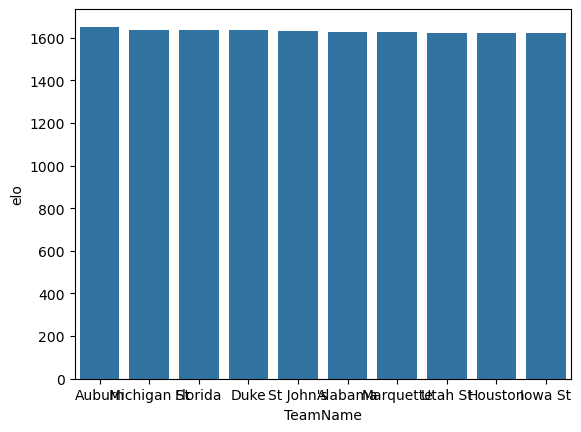

In [56]:
sns.barplot(top_teams, x = 'TeamName', y = 'elo')

In [70]:
# vary k from 40 to 20 ...

In [10]:
def make_final_elo_df(year, score_result_df, k_scheme, home_team_adjustment = 0, fix_k = False, team_elo_dict = None):

    season_df = score_result_df.loc[score_result_df['Season'] == year]

    # get all unique team ids in the season:
    all_team_ids = np.unique(season_df[['WTeamID', 'LTeamID']].values)

    if team_elo_dict is None:
        # initialize all teams' elo to 1500 to begin the season
        team_elo_dict = {int(team):[1500] for team in all_team_ids}

    for rownum, rowvals in tqdm(season_df.iterrows()):
        
        winning_team = int(rowvals['WTeamID'])
        losing_team = int(rowvals['LTeamID'])

        winning_team_prev_elo = team_elo_dict[winning_team][-1]
        losing_team_prev_elo = team_elo_dict[losing_team][-1]

        conf_game = is_conference_game(team1 = winning_team, 
                                       team2 = losing_team,
                                       season = year, 
                                       conf_df = conf_data)
        if fix_k:
            this_k = k_scheme['fixed']
        else:
            if conf_game:
                this_k = k_scheme['conf']
            else:
                this_k = k_scheme['ooc']

        if home_team_adjustment != 0:
            # if the winning team was at home ... 
            if rowvals['WLoc'] == 'H':
                winning_elo_adj = home_team_adjustment
                losing_elo_adj = 0
            
            # if the losing team was at home ... 
            elif rowvals['WLoc'] == 'A':
                winning_elo_adj = 0
                losing_elo_adj = home_team_adjustment
            
            # if neutral site, neither team gets an elo boost
            elif rowvals['WLoc'] == 'N':
                winning_elo_adj = 0
                losing_elo_adj = 0

        # useful for conference tourney games that lack this data ... 
        else:
            winning_elo_adj = 0
            losing_elo_adj = 0

            


        new_winner_elo, new_loser_elo = update_elo(prev_elo1=winning_team_prev_elo,
                                                prev_elo2 = losing_team_prev_elo,
                                                k = this_k,
                                                winner = 1,
                                                hc_boost_1 = winning_elo_adj,
                                                hc_boost_2= losing_elo_adj
                                                )
        
        team_elo_dict[winning_team].append(new_winner_elo)
        team_elo_dict[losing_team].append(new_loser_elo)

    final_elos = {team_id:elo_scores[-1] for team_id, elo_scores in team_elo_dict.items()}
    final_elo_df = pd.DataFrame.from_dict(final_elos, orient = 'index')
    final_elo_df.columns = ['elo']
    final_elo_df = pd.merge(left = final_elo_df, right = team_data, left_index=True, right_on = 'TeamID')
    final_elo_df = final_elo_df.sort_values('elo', ascending = False)

    return team_elo_dict, final_elo_df





3482it [00:01, 2075.85it/s]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Auburn'),
  Text(1, 0, 'Florida'),
  Text(2, 0, 'Alabama'),
  Text(3, 0, 'Michigan St'),
  Text(4, 0, 'Marquette'),
  Text(5, 0, 'Duke'),
  Text(6, 0, 'Tennessee'),
  Text(7, 0, "St John's"),
  Text(8, 0, 'Utah St'),
  Text(9, 0, 'Iowa St')])

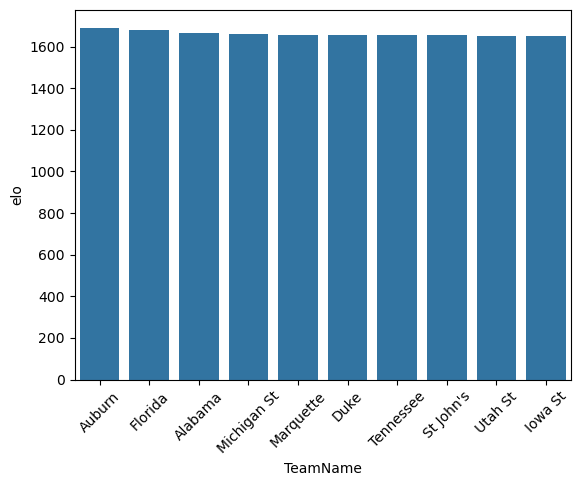

In [ ]:
k_dict = {'conf':20,
          'ooc':30,
          'fixed': 40}

team_elo_dict_2025, final_elo_df_2025 = make_final_elo_df(year = 2025, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme = k_dict, fix_k = False)
sns.barplot(final_elo_df_2025.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)


0it [00:00, ?it/s]

3482it [00:01, 1749.35it/s]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Auburn'),
  Text(1, 0, 'Florida'),
  Text(2, 0, 'Alabama'),
  Text(3, 0, 'UC Irvine'),
  Text(4, 0, 'Utah St'),
  Text(5, 0, 'Michigan St'),
  Text(6, 0, 'Oregon'),
  Text(7, 0, 'Duke'),
  Text(8, 0, 'Marquette'),
  Text(9, 0, 'Drake')])

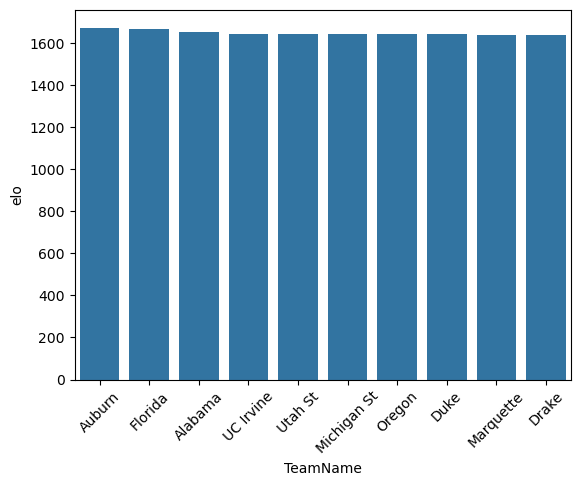

In [217]:
k_dict = {'conf':20,
          'ooc':30,
          'fixed': 40}

team_elo_dict_2025, final_elo_df_2025 = make_final_elo_df(year = 2025, score_result_df=raw_reg_szn, team_elo_dict=None, 
                                                          k_scheme = k_dict, fix_k = False, home_team_adjustment=70)
sns.barplot(final_elo_df_2025.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)


3482it [00:00, 28351.78it/s]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Auburn'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'Florida'),
  Text(3, 0, 'Duke'),
  Text(4, 0, 'Michigan St'),
  Text(5, 0, 'Marquette'),
  Text(6, 0, "St John's"),
  Text(7, 0, 'Utah St'),
  Text(8, 0, 'Houston'),
  Text(9, 0, 'Iowa St')])

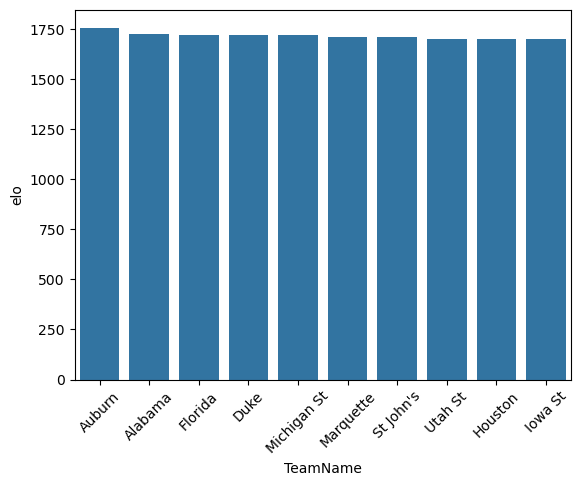

In [76]:
# see what happens after the conference tourneys ...
postcon_team_elo_dict_2025, postcon_final_elo_df_2025 = make_final_elo_df(year = 2025, score_result_df=raw_reg_szn, team_elo_dict=team_elo_dict_2025)
sns.barplot(postcon_final_elo_df_2025.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)


5607it [00:00, 29510.67it/s]


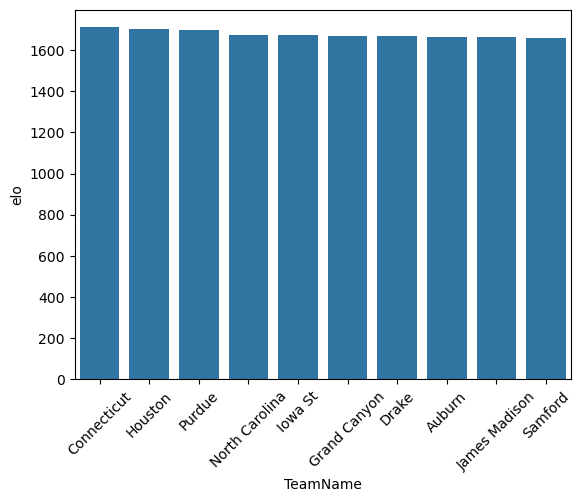

302it [00:00, 30703.67it/s]


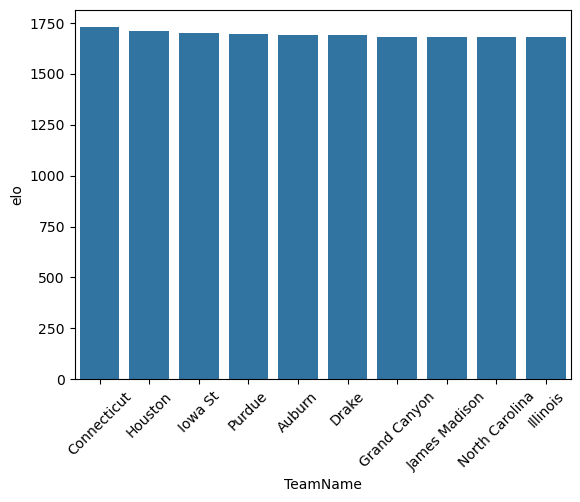

In [78]:
team_elo_dict_2024, final_elo_df_2024 = make_final_elo_df(year = 2024, score_result_df=raw_reg_szn, team_elo_dict=None)
sns.barplot(final_elo_df_2024.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)
plt.show()

plt.figure()
# see what happens after the conference tourneys ...
postcon_team_elo_dict_2024, postcon_final_elo_df_2024 = make_final_elo_df(year = 2024, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict_2024)
sns.barplot(postcon_final_elo_df_2024.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)
plt.show()



In [66]:
final_elo_df_2024.head(30)

elo  TeamID        TeamName  FirstD1Season  LastD1Season
62   1710.733291    1163     Connecticut           1985          2025
121  1705.097692    1222         Houston           1985          2025
244  1697.175304    1345          Purdue           1985          2025
213  1673.337430    1314  North Carolina           1985          2025
134  1673.039837    1235         Iowa St           1985          2025
112  1669.462137    1213    Grand Canyon           2014          2025
78   1666.470932    1179           Drake           1985          2025
19   1665.468303    1120          Auburn           1985          2025
140  1664.777403    1241   James Madison           1985          2025
258  1660.335006    1359         Samford           1985          2025
131  1654.337126    1232      Indiana St           1985          2025
127  1653.862024    1228        Illinois           1985          2025
335  1653.391648    1436         Vermont           1985          2025
275  1650.915669    1376  South Carolina           1985          2025
169  1649.644503    1270      McNeese St           1985          2025
204  1644.337852    1305          Nevada           1985          2025
93   1642.737050    1194     FL Atlantic           1994          2025
57   1642.211848    1158  Col Charleston           1992          2025
287  1641.796080    1388    St Mary's CA           1985          2025
11   1641.419383    1112         Arizona           1985          2025
328  1641.400767    1429         Utah St           1985          2025
206  1636.939071    1307      New Mexico           1985          2025
10   1636.233722    1111  Appalachian St           1985          2025
296  1636.010330    1397       Tennessee           1985          2025
72   1635.443759    1173          Dayton           1985          2025
277  1633.734626    1378   South Florida           1985          2025
242  1633.354612    1343       Princeton           1985          2025
80   1627.895324    1181            Duke           1985          2025
349  1626.213898    1450   Washington St           1985          2025
145  1624.561533    1246        Kentucky           1985          2025

5602it [00:00, 21473.65it/s]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Houston'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'FL Atlantic'),
  Text(3, 0, 'Purdue'),
  Text(4, 0, 'Col Charleston'),
  Text(5, 0, 'UCLA'),
  Text(6, 0, 'Arizona'),
  Text(7, 0, 'Marquette'),
  Text(8, 0, 'Gonzaga'),
  Text(9, 0, 'Kansas')])

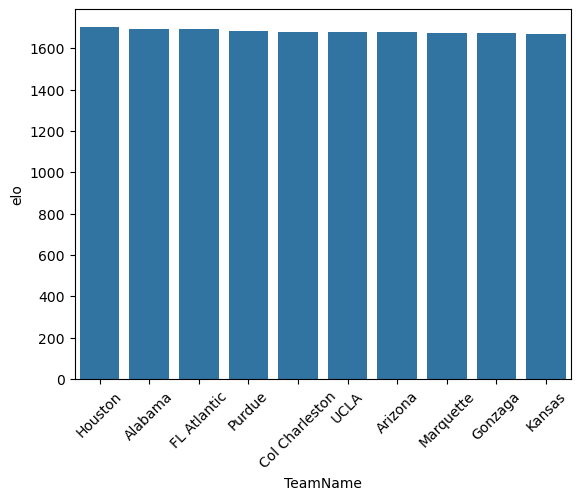

In [69]:
final_elo_df_2023 = make_final_elo_df(year = 2023)
sns.barplot(final_elo_df_2023.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
plt.xticks(rotation = 45)


In [ ]:
# season_seeds = tourney_seeds.loc[tourney_seeds['Season'] == 2024]
# # seed_team_dict = tourney_seeds.set_index('Seed')['TeamID'].to_dict()
# seed_team_dict = dict(zip(season_seeds['Seed'], season_seeds['TeamID']))

# season_tourney_slots = tourney_slots.loc[tourney_slots['Season'] == 2024]
# season_tourney_results = raw_mm_tourn.loc[raw_mm_tourn['Season'] == 2024]
# # season_seed_slots = seed_slots.loc[seed_slots['Season'] == 2024]

# round_matchup_dict = {}
# for rownum, rowvals in season_tourney_slots.iterrows():
#     game_slot = rowvals['Slot']

#     print(f'game_slot == {game_slot}')

#     strong_seed, weak_seed = season_tourney_slots[['StrongSeed', 'WeakSeed']].loc[season_tourney_slots['Slot'] == game_slot].values.tolist()[0]

#     print(f'strong_seed == {strong_seed}')
#     print(f'weak_seed == {weak_seed}')

    
    
#     try:
#         team1 = seed_team_dict[strong_seed]
#         team2 = seed_team_dict[weak_seed]

#     except KeyError as e: 

#         # account for the fact that there might be play-in games ... 
#         # assign the non-a/b listed seed as the winner of the a vs b game

#         if strong_seed not in seed_team_dict.keys():
#             problematic_seed = strong_seed
#         elif weak_seed not in seed_team_dict.keys():
#             problematic_seed = weak_seed
    
#         # strip away the a and b, get both combos, search for winner of that game ... 
#         play_in_team_a = seed_team_dict[f'{problematic_seed}a']
#         play_in_team_b = seed_team_dict[f'{problematic_seed}b']

#         play_in_winner = int(season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([play_in_team_a, play_in_team_b]), axis = 1), 'WTeamID'].values[0])

#         # add this play_in_winner as the official seed in the dict
#         print(f'prob seed = {problematic_seed}')
#         seed_team_dict[problematic_seed] = play_in_winner

#         team1 = seed_team_dict[strong_seed]
#         team2 = seed_team_dict[weak_seed]

#     print(f'team1 == {team1}')
#     print(f'team2 == {team2}')

#     # winner = int(season_tourney_results['WTeamID'].loc[(season_tourney_results['WTeamID'].isin([team1, team2])) & (season_tourney_results['LTeamID'].isin([team1, team2]))].values[0])
#     winner = int(season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID'].values[0])
#     # winner = season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID']
#     print(f'winner = {winner}')

#     # add the winner as a new entry with the slot name as key
#     seed_team_dict[game_slot] = winner

#     round_num = seed_slots['GameRound'].loc[seed_slots['GameSlot'] == game_slot].values[0]
#     if round_num in round_matchup_dict.keys():
#         round_matchup_dict[round_num].append([team1, team2, winner])
#     else:
#         round_matchup_dict[round_num] = [[team1, team2, winner]]


In [11]:
def create_tournament_matchup_dict(season):
    season_seeds = tourney_seeds.loc[tourney_seeds['Season'] == season]
    # seed_team_dict = tourney_seeds.set_index('Seed')['TeamID'].to_dict()
    seed_team_dict = dict(zip(season_seeds['Seed'], season_seeds['TeamID']))

    season_tourney_slots = tourney_slots.loc[tourney_slots['Season'] == season]
    season_tourney_results = raw_mm_tourn.loc[raw_mm_tourn['Season'] == season]
    # season_seed_slots = seed_slots.loc[seed_slots['Season'] == 2024]

    round_matchup_dict = {}
    for rownum, rowvals in season_tourney_slots.iterrows():
        game_slot = rowvals['Slot']

        # print(f'game_slot == {game_slot}')

        strong_seed, weak_seed = season_tourney_slots[['StrongSeed', 'WeakSeed']].loc[season_tourney_slots['Slot'] == game_slot].values.tolist()[0]

        # print(f'strong_seed == {strong_seed}')
        # print(f'weak_seed == {weak_seed}')

        
        
        try:
            team1 = seed_team_dict[strong_seed]
            team2 = seed_team_dict[weak_seed]

        except KeyError as e: 

            # account for the fact that there might be play-in games ... 
            # assign the non-a/b listed seed as the winner of the a vs b game

            if strong_seed not in seed_team_dict.keys():
                problematic_seed = strong_seed
            elif weak_seed not in seed_team_dict.keys():
                problematic_seed = weak_seed
        
            # strip away the a and b, get both combos, search for winner of that game ... 
            play_in_team_a = seed_team_dict[f'{problematic_seed}a']
            play_in_team_b = seed_team_dict[f'{problematic_seed}b']

            play_in_winner = int(season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([play_in_team_a, play_in_team_b]), axis = 1), 'WTeamID'].values[0])

            # add this play_in_winner as the official seed in the dict
            seed_team_dict[problematic_seed] = play_in_winner

            team1 = seed_team_dict[strong_seed]
            team2 = seed_team_dict[weak_seed]

        # winner = int(season_tourney_results['WTeamID'].loc[(season_tourney_results['WTeamID'].isin([team1, team2])) & (season_tourney_results['LTeamID'].isin([team1, team2]))].values[0])
        winner = int(season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID'].values[0])
        # winner = season_tourney_results.loc[season_tourney_results.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID']

        # add the winner as a new entry with the slot name as key
        seed_team_dict[game_slot] = winner

        round_num = int(seed_slots['GameRound'].loc[seed_slots['GameSlot'] == game_slot].values[0])
        if round_num in round_matchup_dict.keys():
            round_matchup_dict[round_num].append([team1, team2, winner])
        else:
            round_matchup_dict[round_num] = [[team1, team2, winner]]

    return round_matchup_dict



In [12]:
round_matchup_dict_2024 = create_tournament_matchup_dict(2024)

In [ ]:
tourney_slots_2024 = tourney_slots.loc[tourney_slots['Season'] == 2024].reset_index(drop = True)

def find_slot_path(seed, tourney_slots):
    # championship slot ends in CH
    championship_slot = tourney_slots['Slot'][tourney_slots['Slot'].str.endswith('CH')].values[0]
    next_slot = tourney_slots['Slot'].loc[(tourney_slots['StrongSeed'] == seed) | (tourney_slots['WeakSeed'] == seed)].values[0]
    poss_slots = [next_slot]
    while next_slot != championship_slot:
        next_slot = tourney_slots['Slot'].loc[(tourney_slots['StrongSeed'] == next_slot) | (tourney_slots['WeakSeed'] == next_slot)].values[0]
        poss_slots.append(next_slot)
    return poss_slots

def games_before_meeting(seed1, seed2, tourney_slots):
    slot_path1 = find_slot_path(seed1, tourney_slots)
    slot_path2 = find_slot_path(seed2, tourney_slots)

    for ind1, slot1 in enumerate(slot_path1):
        for ind2, slot2 in enumerate(slot_path2):
            if slot1 == slot2:
                return ind1, ind2

In [67]:
def find_brier_score(tourney_results, pairwise_matchup_probs):
    '''
    get the brier score for a given set of matchup probs and tournament results
    '''
    running_error = 0
    running_matchup_counter = 0

    for round_num,matchup_list in tourney_results.items():
        for matchup in matchup_list:
            winner = matchup[2]
            teams = set(matchup)
            loser = list(teams.difference(set([winner])))[0]
            outcome_prob = pairwise_matchup_probs[winner][loser]

            squared_loss = (1-outcome_prob)**2
            running_error += squared_loss
            running_matchup_counter += 1

    return running_error / running_matchup_counter


In [201]:
raw_reg_szn

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0         1985      20     1228      81     1328      64    N      0
1         1985      25     1106      77     1354      70    H      0
2         1985      25     1112      63     1223      56    H      0
3         1985      25     1165      70     1432      54    H      0
4         1985      25     1192      86     1447      74    H      0
...        ...     ...      ...     ...      ...     ...  ...    ...
190766    2025      85     1401      75     1328      68    H      0
190767    2025      85     1405      86     1325      83    A      0
190768    2025      85     1428      69     1153      66    H      0
190769    2025      85     1444      74     1123      71    A      0
190770    2025      85     1461      83     1201      72    H      1

[190771 rows x 8 columns]

In [59]:
k_dict = {'conf':20,
            'ooc':40,
            'fixed': 20}


def prelim_analysis(year, k_dict, home_court_advantage = 0):

    

    

    team_elo_dict, final_elo_df = make_final_elo_df(year = year, score_result_df=raw_reg_szn, home_team_adjustment = home_court_advantage, 
                                                    team_elo_dict=None, k_scheme=k_dict, fix_k = False)

    postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = year, score_result_df=raw_conf_tourn, home_team_adjustment = 0, 
                                                                    team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

    final_postcon_team_elo_dict = {team:elo[-1] for team, elo in postcon_team_elo_dict.items()}

    round_matchup_dict_2024 = create_tournament_matchup_dict(2024)

    pairwise_winprob_dict = {}

    for team1, elo1 in final_postcon_team_elo_dict.items():
        pairwise_winprob_dict[team1] = {}
        for team2, elo2 in final_postcon_team_elo_dict.items():
            # no home court boost in march madness
            pairwise_winprob_dict[team1][team2] = get_elo_win_prob(elo1, elo2, home_court_advantage_boost_1 = 0, home_court_advantage_boost_2 = 0)




    brier_score = find_brier_score(tourney_results = round_matchup_dict_2024, 
                                pairwise_matchup_probs = pairwise_winprob_dict)

    return(brier_score)

In [228]:
k_dict = {'conf':20,
            'ooc':40,
            'fixed': 20}
prelim_analysis(year = 2022, k_dict = k_dict, home_court_advantage=70)

5345it [00:02, 2142.22it/s]
301it [00:00, 2212.49it/s]


0.2518386107741726

In [200]:
k_dict = {'conf':20,
            'ooc':40,
            'fixed': 20}
prelim_analysis(year = 2022, k_dict = k_dict)

5345it [00:03, 1564.30it/s]
301it [00:00, 2121.11it/s]


0.2521525068407864

In [ ]:
# figure out what the elo paths would be in order for two teams to play each other in the bracket ... 
# that's not really in the spirit of elos though. 
# more of a gambling approach. 

In [68]:
k_dict = {'conf':20,
          'ooc':40,
          'fixed': 20}


team_elo_dict_2024, final_elo_df_2024 = make_final_elo_df(year = 2024, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
# sns.barplot(final_elo_df_2024.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
# plt.xticks(rotation = 45)
# plt.show()

# plt.figure()
# see what happens after the conference tourneys ...
postcon_team_elo_dict_2024, postcon_final_elo_df_2024 = make_final_elo_df(year = 2024, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict_2024, k_scheme=k_dict, fix_k= True)
# sns.barplot(postcon_final_elo_df_2024.sort_values('elo', ascending = False).head(10), x = 'TeamName', y = 'elo')
# plt.xticks(rotation = 45)
# plt.show()

final_postcon_team_elo_dict_2024 = {team:elo[-1] for team, elo in postcon_team_elo_dict_2024.items()}

round_matchup_dict_2024 = create_tournament_matchup_dict(2024)

pairwise_winprob_dict_2024 = {}

for team1, elo1 in final_postcon_team_elo_dict_2024.items():
    pairwise_winprob_dict_2024[team1] = {}
    for team2, elo2 in final_postcon_team_elo_dict_2024.items():
        pairwise_winprob_dict_2024[team1][team2] = get_elo_win_prob(elo1, elo2, home_court_advantage_boost_1 = 0, home_court_advantage_boost_2 = 0)




brier_score_2024 = find_brier_score(tourney_results = round_matchup_dict_2024, 
                               pairwise_matchup_probs = pairwise_winprob_dict_2024)

print(brier_score_2024)

5607it [00:02, 2110.56it/s]
302it [00:00, 2155.49it/s]


0.22700343675574916


In [195]:
brier_score_2024

0.23414120853504142

In [179]:
round_matchup_dict_2024

{1: [[1163, 1391, 1163],
  [1235, 1355, 1235],
  [1228, 1287, 1228],
  [1120, 1463, 1463],
  [1361, 1412, 1361],
  [1140, 1182, 1182],
  [1450, 1179, 1450],
  [1194, 1321, 1321],
  [1314, 1447, 1314],
  [1112, 1253, 1112],
  [1124, 1159, 1124],
  [1104, 1158, 1104],
  [1388, 1213, 1213],
  [1155, 1307, 1155],
  [1173, 1305, 1173],
  [1280, 1277, 1277],
  [1345, 1212, 1345],
  [1397, 1389, 1397],
  [1166, 1103, 1166],
  [1242, 1359, 1242],
  [1211, 1270, 1211],
  [1376, 1332, 1332],
  [1400, 1161, 1400],
  [1429, 1395, 1429],
  [1222, 1255, 1222],
  [1266, 1443, 1266],
  [1246, 1324, 1324],
  [1181, 1436, 1181],
  [1458, 1241, 1241],
  [1403, 1301, 1301],
  [1196, 1160, 1160],
  [1304, 1401, 1401]],
 2: [[1163, 1321, 1163],
  [1235, 1450, 1235],
  [1228, 1182, 1228],
  [1463, 1361, 1361],
  [1314, 1277, 1314],
  [1112, 1173, 1112],
  [1124, 1155, 1155],
  [1104, 1213, 1104],
  [1345, 1429, 1345],
  [1397, 1400, 1397],
  [1166, 1332, 1166],
  [1242, 1211, 1211],
  [1222, 1401, 1222],
  [

In [182]:
teams = set(round_matchup_dict_2024[0][0])

In [183]:
teams

{1224, 1447}

1447

In [ ]:
# running_error = 0
# running_matchup_counter = 0

# for round_num,matchup_list in round_matchup_dict_2024.items():
#     for matchup in matchup_list:
#         winner = matchup[2]
#         teams = set(matchup)
#         loser = list(teams.difference(set([winner])))[0]
#         outcome_prob = pairwise_winprob_dict_2024[winner][loser]

#         squared_loss = (1-outcome_prob)**2
#         running_error += squared_loss
#         running_matchup_counter += 1

# print(running_error / running_matchup_counter)


0.23414120853504142


In [178]:
pairwise_winprob_dict_2024

{1101: {1101: 0.5,
  1102: 0.6632180725852934,
  1103: 0.23832919319718054,
  1104: 0.30803446817462427,
  1105: 0.7013241683024234,
  1106: 0.6549853002927262,
  1107: 0.5936390602249737,
  1108: 0.6477010235932609,
  1110: 0.4628910154138239,
  1111: 0.22959835512465276,
  1112: 0.2130513287160764,
  1113: 0.4871895106469216,
  1114: 0.33445262978617546,
  1115: 0.6222081100881973,
  1116: 0.46035991592334624,
  1117: 0.3870000498708032,
  1119: 0.6849649548249084,
  1120: 0.13721289045082732,
  1122: 0.4309251264861395,
  1123: 0.4657080415681014,
  1124: 0.2473215904153364,
  1125: 0.3755768206815565,
  1126: 0.4672602286931427,
  1127: 0.4892213882682823,
  1129: 0.31991538987717527,
  1130: 0.32468782246005334,
  1131: 0.4621210388524834,
  1132: 0.33694595792629456,
  1133: 0.29824361727737525,
  1135: 0.5703546961969336,
  1136: 0.39234766809563765,
  1137: 0.5748187575983871,
  1138: 0.8774167551220405,
  1139: 0.3825161563060525,
  1140: 0.23256020136916952,
  1141: 0.4311637

In [268]:
team_feats_2024

TeamID  PointDiff  NumPossDiff  OEffDiff   FGPDiff  FGP3Diff   FTPDiff  \
0      1101  -2.645161     0.370968 -0.039989 -0.043134  0.006138  0.053645   
1      1102  -6.193548    -3.774194 -0.043604 -0.027478 -0.008001 -0.060352   
2      1103   5.531250     1.109375  0.059196  0.021929  0.025824  0.044309   
3      1104   9.687500     1.578125  0.096021  0.036708  0.039874  0.043273   
4      1105  -7.090909    -0.530303 -0.073975 -0.007286 -0.070017 -0.033940   
..      ...        ...          ...       ...       ...       ...       ...   
357    1474  -5.258065     0.193548 -0.065762 -0.045270 -0.012042 -0.008193   
358    1475  -8.034483    -0.517241 -0.093120 -0.033458 -0.008061 -0.008964   
359    1476 -14.000000    -3.350000 -0.137540 -0.044495 -0.052567 -0.051862   
360    1477  -9.333333    -1.683333 -0.105660 -0.081510 -0.063923 -0.018740   
361    1478  -1.517241    -2.362069  0.009245 -0.014583  0.001087  0.056104   

      PP3Diff ConfAbbrev          elo  
0   -0.057109        wac  1426.222688  
1    0.104693        mwc  1340.137694  
2    0.047006        mac  1603.932734  
3    0.100279        sec  1585.112032  
4   -0.097817       swac  1191.886242  
..        ...        ...          ...  
357  0.039345      a_sun  1325.529353  
358 -0.013523        ovc  1084.065202  
359  0.008018        nec   982.150543  
360  0.152551  southland  1310.034070  
361  0.044580        nec  1349.945701  

[362 rows x 10 columns]

In [284]:
team1_dict

{'TeamID_1': 1101,
 'PointDiff_1': -2.6451612903225805,
 'NumPossDiff_1': 0.3709677419354839,
 'OEffDiff_1': -0.039989347844640796,
 'FGPDiff_1': -0.043133734306555704,
 'FGP3Diff_1': 0.00613768126232357,
 'FTPDiff_1': 0.05364479611725023,
 'PP3Diff_1': -0.05710866345451972,
 'ConfAbbrev_1': 'wac',
 'elo_1': 1426.2226877620217,
 'TeamID_2': 1102,
 'PointDiff_2': -6.193548387096774,
 'NumPossDiff_2': -3.774193548387097,
 'OEffDiff_2': -0.043603778178016056,
 'FGPDiff_2': -0.027477916150521642,
 'FGP3Diff_2': -0.008001258554153573,
 'FTPDiff_2': -0.06035190704333601,
 'PP3Diff_2': 0.10469277547361393,
 'ConfAbbrev_2': 'mwc',
 'elo_2': 1340.1376935025228}

In [282]:
team2_dict

{'TeamID_2': 1102,
 'PointDiff_2': -6.193548387096774,
 'NumPossDiff_2': -3.774193548387097,
 'OEffDiff_2': -0.043603778178016056,
 'FGPDiff_2': -0.027477916150521642,
 'FGP3Diff_2': -0.008001258554153573,
 'FTPDiff_2': -0.06035190704333601,
 'PP3Diff_2': 0.10469277547361393,
 'ConfAbbrev_2': 'mwc',
 'elo_2': 1340.1376935025228}

In [279]:
team1_vals

[1101,
 -2.6451612903225805,
 0.3709677419354839,
 -0.039989347844640796,
 -0.043133734306555704,
 0.00613768126232357,
 0.05364479611725023,
 -0.05710866345451972,
 'wac',
 1426.2226877620217]

In [280]:
team1_dict

{'TeamID_1': 1101,
 'PointDiff_1': -2.6451612903225805,
 'NumPossDiff_1': 0.3709677419354839,
 'OEffDiff_1': -0.039989347844640796,
 'FGPDiff_1': -0.043133734306555704,
 'FGP3Diff_1': 0.00613768126232357,
 'FTPDiff_1': 0.05364479611725023,
 'PP3Diff_1': -0.05710866345451972,
 'ConfAbbrev_1': 'wac',
 'elo_1': 1426.2226877620217}

In [292]:
team_pairs = [sorted(pair) for pair in team_pairs]
team_pairs

[[1101, 1102],
 [1101, 1103],
 [1101, 1104],
 [1101, 1105],
 [1101, 1106],
 [1101, 1107],
 [1101, 1108],
 [1101, 1110],
 [1101, 1111],
 [1101, 1112],
 [1101, 1113],
 [1101, 1114],
 [1101, 1115],
 [1101, 1116],
 [1101, 1117],
 [1101, 1119],
 [1101, 1120],
 [1101, 1122],
 [1101, 1123],
 [1101, 1124],
 [1101, 1125],
 [1101, 1126],
 [1101, 1127],
 [1101, 1129],
 [1101, 1130],
 [1101, 1131],
 [1101, 1132],
 [1101, 1133],
 [1101, 1135],
 [1101, 1136],
 [1101, 1137],
 [1101, 1138],
 [1101, 1139],
 [1101, 1140],
 [1101, 1141],
 [1101, 1142],
 [1101, 1143],
 [1101, 1144],
 [1101, 1145],
 [1101, 1146],
 [1101, 1148],
 [1101, 1149],
 [1101, 1150],
 [1101, 1151],
 [1101, 1152],
 [1101, 1153],
 [1101, 1154],
 [1101, 1155],
 [1101, 1156],
 [1101, 1157],
 [1101, 1158],
 [1101, 1159],
 [1101, 1160],
 [1101, 1161],
 [1101, 1162],
 [1101, 1163],
 [1101, 1164],
 [1101, 1165],
 [1101, 1166],
 [1101, 1167],
 [1101, 1168],
 [1101, 1169],
 [1101, 1170],
 [1101, 1171],
 [1101, 1172],
 [1101, 1173],
 [1101, 11

In [ ]:
stat_feats = ['PointDiff', 'NumPossDiff', 'OEffDiff', 'FGPDiff', 'FGP3Diff', 'FTPDiff', 'PP3Diff']

my_regszn_2024 = train_reg_szn_diffs_data.loc[train_reg_szn_diffs_data['Season'] == 2024]
conf_data_2024 = conf_data.loc[conf_data['Season'] == 2024]
regszn_avgs_2024 = my_regszn_2024.groupby('TeamID')[stat_feats].mean()

regszn_avgs_2024 = pd.merge(left = regszn_avgs_2024, right = conf_data_2024[['TeamID', 'ConfAbbrev']], on = 'TeamID')

team_feats_2024 = pd.merge(left = regszn_avgs_2024, right = postcon_final_elo_df_2024[['elo', 'TeamID']], on = 'TeamID')

# note that this should always have the lower TeamID playing against the higher TeamID ... 

# while building pairwise march madness dataset, check to see if that matchup actually occurred first. 

team_pairs = list(itertools.combinations(team_feats_2024['TeamID'], 2))
sorted_team_pairs = [sorted(pair) for pair in team_pairs]

raw_mm_tourn_2024 = raw_mm_tourn.loc[raw_mm_tourn['Season'] == 2024]

all_pairwise_data = []
all_pairwise_diffs_data = []

for team1, team2 in tqdm(sorted_team_pairs):

    try:
        # check if this matchup occurred in march madness. if it didn't we won't have a label for it, so we won't train on it... 
        winner_id = int(raw_mm_tourn_2024.loc[raw_mm_tourn_2024.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID'].values[0])
        if winner_id == team1:
            winner = 1
        elif winner_id == team2:
            winner = 2

    except IndexError as e: # will throw index error if no such matchup occurred; move onto next pair
         continue
    
    team1_vals = team_feats_2024.loc[team_feats_2024['TeamID'] == team1].values.tolist()[0]
    team1_dict = dict(zip([f'{col}_1' for col in team_feats_2024.columns], team1_vals))

    team2_vals = team_feats_2024.loc[team_feats_2024['TeamID'] == team2].values.tolist()[0]
    team2_dict = dict(zip([f'{col}_2' for col in team_feats_2024.columns], team2_vals))

    diffs_dict = {}
    for team_feat in team1_dict.keys():
        
        # remove the _# so that we can use for team2 as well
        team_feat_stem = team_feat[:-2]

        # if this is a stat-related column, find the difference between team 1 and team 2
        if team_feat_stem in stat_feats:
            diffs_dict[f'{team_feat_stem}_diff'] = team1_dict[f'{team_feat_stem}_1'] - team2_dict[f'{team_feat_stem}_2']

        # if it's not a numeric stat column, add existing elements to dict
        else:
            diffs_dict[f'{team_feat_stem}_1'] = team1_dict[f'{team_feat_stem}_1']
            diffs_dict[f'{team_feat_stem}_2'] = team2_dict[f'{team_feat_stem}_2']
    
    diffs_dict.update({'winner': winner})
    all_pairwise_diffs_data.append(diffs_dict)
        

    team1_dict.update(team2_dict)
    team1_dict.update({'winner':winner})

    all_pairwise_data.append(team1_dict)

    


pairwise_df_2024 = pd.DataFrame(all_pairwise_data)
pairwise_diffs_df_2024 = pd.DataFrame(all_pairwise_diffs_data)

# concat confs, then drop team ids and conference data
concat_confs = pairwise_df_2024['ConfAbbrev_1']+ '_' + pairwise_df_2024['ConfAbbrev_2']
pairwise_df_2024.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_df_2024.shape[1])

pairwise_df_2024.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)

# concat confs, then drop team ids and conference data
concat_confs = pairwise_diffs_df_2024['ConfAbbrev_1']+ '_' + pairwise_diffs_df_2024['ConfAbbrev_2']
pairwise_diffs_df_2024.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_diffs_df_2024.shape[1])

pairwise_diffs_df_2024.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)


100%|██████████| 65341/65341 [00:52<00:00, 1256.13it/s]


In [ ]:
# # slower approach

# def create_x_y_data(season, diffs_data, postcon_final_elo_df_szn, include_winner_in_x = False):

#     stat_feats = ['PointDiff', 'NumPossDiff', 'OEffDiff', 'FGPDiff', 'FGP3Diff', 'FTPDiff', 'PP3Diff']

#     my_regszn_szn = diffs_data.loc[diffs_data['Season'] == season]
#     conf_data_szn = conf_data.loc[conf_data['Season'] == season]
#     regszn_avgs_szn = my_regszn_szn.groupby('TeamID')[stat_feats].mean()
#     raw_mm_tourn_szn = raw_mm_tourn.loc[raw_mm_tourn['Season'] == season]

#     regszn_avgs_szn = pd.merge(left = regszn_avgs_szn, right = conf_data_szn[['TeamID', 'ConfAbbrev']], on = 'TeamID')

#     team_feats_szn = pd.merge(left = regszn_avgs_szn, right = postcon_final_elo_df_szn[['elo', 'TeamID']], on = 'TeamID')

#     # note that this should always have the lower TeamID playing against the higher TeamID ... 

#     # while building pairwise march madness dataset, check to see if that matchup actually occurred first. 

#     team_pairs = list(itertools.combinations(team_feats_szn['TeamID'], 2))
#     sorted_team_pairs = [sorted(pair) for pair in team_pairs]

    

#     all_pairwise_data = []
#     all_pairwise_diffs_data = []
#     winner_list = []

#     for team1, team2 in tqdm(sorted_team_pairs):

#         try:
#             # check if this matchup occurred in march madness. if it didn't we won't have a label for it, so we won't train on it... 
#             winner_id = int(raw_mm_tourn_szn.loc[raw_mm_tourn_szn.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID'].values[0])
#             if winner_id == team1:
#                 winner = 1
#             elif winner_id == team2:
#                 winner = 2

#         except IndexError as e: # will throw index error if no such matchup occurred; move onto next pair
#             continue
        
#         team1_vals = team_feats_szn.loc[team_feats_szn['TeamID'] == team1].values.tolist()[0]
#         team1_dict = dict(zip([f'{col}_1' for col in team_feats_szn.columns], team1_vals))

#         team2_vals = team_feats_szn.loc[team_feats_szn['TeamID'] == team2].values.tolist()[0]
#         team2_dict = dict(zip([f'{col}_2' for col in team_feats_szn.columns], team2_vals))

#         diffs_dict = {}
#         for team_feat in team1_dict.keys():
            
#             # remove the _# so that we can use for team2 as well
#             team_feat_stem = team_feat[:-2]

#             # if this is a stat-related column, find the difference between team 1 and team 2
#             if team_feat_stem in stat_feats:
#                 diffs_dict[f'{team_feat_stem}_diff'] = team1_dict[f'{team_feat_stem}_1'] - team2_dict[f'{team_feat_stem}_2']

#             # if it's not a numeric stat column, add existing elements to dict
#             else:
#                 diffs_dict[f'{team_feat_stem}_1'] = team1_dict[f'{team_feat_stem}_1']
#                 diffs_dict[f'{team_feat_stem}_2'] = team2_dict[f'{team_feat_stem}_2']
        
#         if include_winner_in_x:
#             diffs_dict.update({'winner': winner})
#             team1_dict.update({'winner':winner})

#         all_pairwise_diffs_data.append(diffs_dict)

#         team1_dict.update(team2_dict)
#         all_pairwise_data.append(team1_dict)

#         winner_list.append(winner)

        


#     pairwise_df_szn = pd.DataFrame(all_pairwise_data)
#     pairwise_diffs_df_szn = pd.DataFrame(all_pairwise_diffs_data)

#     # concat confs, then drop team ids and conference data
#     concat_confs = pairwise_df_szn['ConfAbbrev_1']+ '_' + pairwise_df_szn['ConfAbbrev_2']
#     pairwise_df_szn.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_df_szn.shape[1])

#     pairwise_df_szn.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)

#     # concat confs, then drop team ids and conference data
#     concat_confs = pairwise_diffs_df_szn['ConfAbbrev_1']+ '_' + pairwise_diffs_df_szn['ConfAbbrev_2']
#     pairwise_diffs_df_szn.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_diffs_df_szn.shape[1])

#     pairwise_diffs_df_szn.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)

#     return pairwise_df_szn, pairwise_diffs_df_szn, winner_list


In [265]:
# faster implementation

def create_x_y_data(season, reg_szn_data, postcon_final_elo_df_szn, stat_feats, include_winner_in_x = False, include_secondary_tourney_data = True):


    raw_mm_tourn = pd.read_csv(os.path.join(path_to_data, 'MNCAATourneyCompactResults.csv'))
    raw_secondary_tourn = pd.read_csv(os.path.join(path_to_data, 'MSecondaryTourneyCompactResults.csv'))
    

    my_regszn_szn = reg_szn_data.loc[reg_szn_data['Season'] == season]
    conf_data_szn = conf_data.loc[conf_data['Season'] == season]
    regszn_avgs_szn = my_regszn_szn.groupby('TeamID')[stat_feats].mean()

    if include_secondary_tourney_data:
        postseason_games = raw_mm_tourn.loc[raw_mm_tourn['Season'] == season]
    else:
        raw_secondary_tourn_szn = raw_secondary_tourn.loc[raw_secondary_tourn['Season'] == season]
        raw_mm_tourn_szn = raw_mm_tourn.loc[raw_mm_tourn['Season'] == season]

        postseason_games = pd.concat([raw_mm_tourn_szn, raw_secondary_tourn_szn], axis = 0, ignore_index=True)
        

    regszn_avgs_szn = pd.merge(left = regszn_avgs_szn, right = conf_data_szn[['TeamID', 'ConfAbbrev']], on = 'TeamID')

    team_feats_szn = pd.merge(left = regszn_avgs_szn, right = postcon_final_elo_df_szn[['elo', 'TeamID']], on = 'TeamID')

    # note that this should always have the lower TeamID playing against the higher TeamID ... 

    # while building pairwise march madness dataset, check to see if that matchup actually occurred first. 

    team_pairs = list(itertools.combinations(team_feats_szn['TeamID'], 2))
    sorted_team_pairs = [sorted(pair) for pair in team_pairs]

    

    all_pairwise_data = []
    all_pairwise_diffs_data = []
    winner_list = []

    # for team1, team2 in tqdm(sorted_team_pairs):
    # for team1, team2 in zip(raw_mm_tourn_szn['WTeamID'], raw_mm_tourn_szn['LTeamID']):

    for rownum, rowvals in postseason_games.iterrows():



        # team1 will always be the team with the lower team ID

        team_ids = [rowvals['WTeamID'], rowvals['LTeamID']]
        team1 = min(team_ids)
        team2 = max(team_ids)

        if team1 == rowvals['WTeamID']:
            winner = 0
        elif team2 == rowvals['WTeamID']:
            winner = 1



        # try:
        #     # check if this matchup occurred in march madness. if it didn't we won't have a label for it, so we won't train on it... 
        #     winner_id = int(raw_mm_tourn_szn.loc[raw_mm_tourn_szn.apply(lambda row: frozenset([row['WTeamID'], row['LTeamID']]) == frozenset([team1, team2]), axis = 1), 'WTeamID'].values[0])
        #     if winner_id == team1:
        #         winner = 1
        #     elif winner_id == team2:
        #         winner = 2

        # except IndexError as e: # will throw index error if no such matchup occurred; move onto next pair
        #     continue
        
        team1_vals = team_feats_szn.loc[team_feats_szn['TeamID'] == team1].values.tolist()[0]
        team1_dict = dict(zip([f'{col}_1' for col in team_feats_szn.columns], team1_vals))

        team2_vals = team_feats_szn.loc[team_feats_szn['TeamID'] == team2].values.tolist()[0]
        team2_dict = dict(zip([f'{col}_2' for col in team_feats_szn.columns], team2_vals))

        diffs_dict = {}
        for team_feat in team1_dict.keys():
            
            # remove the _# so that we can use for team2 as well
            team_feat_stem = team_feat[:-2]

            # if this is a stat-related column, find the difference between team 1 and team 2
            if team_feat_stem in stat_feats:
                diffs_dict[f'{team_feat_stem}_diff'] = team1_dict[f'{team_feat_stem}_1'] - team2_dict[f'{team_feat_stem}_2']

            # if it's not a numeric stat column, add existing elements to dict
            else:
                diffs_dict[f'{team_feat_stem}_1'] = team1_dict[f'{team_feat_stem}_1']
                diffs_dict[f'{team_feat_stem}_2'] = team2_dict[f'{team_feat_stem}_2']
        
        if include_winner_in_x:
            diffs_dict.update({'winner': winner})
            team1_dict.update({'winner':winner})

        all_pairwise_diffs_data.append(diffs_dict)

        team1_dict.update(team2_dict)
        all_pairwise_data.append(team1_dict)

        
        winner_list.append(winner)

        


    pairwise_df_szn = pd.DataFrame(all_pairwise_data)
    pairwise_diffs_df_szn = pd.DataFrame(all_pairwise_diffs_data)

    # concat confs, then drop team ids and conference data
    concat_confs = pairwise_df_szn['ConfAbbrev_1']+ '_' + pairwise_df_szn['ConfAbbrev_2']
    pairwise_df_szn.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_df_szn.shape[1])

    pairwise_df_szn.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)

    # concat confs, then drop team ids and conference data
    concat_confs = pairwise_diffs_df_szn['ConfAbbrev_1']+ '_' + pairwise_diffs_df_szn['ConfAbbrev_2']
    pairwise_diffs_df_szn.insert(column = 'merged_conf', value = concat_confs, loc = pairwise_diffs_df_szn.shape[1])

    pairwise_diffs_df_szn.drop(columns = ['ConfAbbrev_1', 'ConfAbbrev_2', 'TeamID_1', 'TeamID_2'], inplace = True)

    return pairwise_df_szn, pairwise_diffs_df_szn, winner_list


In [337]:
x_pairwise_2024, x_pairwise_diffs_2024, y_2024 = create_x_y_data(season = 2024, postcon_final_elo_df_szn = postcon_final_elo_df_2024, include_winner_in_x = False)

100%|██████████| 65341/65341 [00:54<00:00, 1204.13it/s]


In [ ]:
# this dataframe was already filtered to only include train years. 
train_reg_szn_diffs_data['Season'].unique()

array([2003, 2004, 2006, 2007, 2008, 2010, 2011, 2013, 2014, 2015, 2017,
       2018, 2021, 2022, 2024])

In [87]:
train_reg_szn_diffs_data

Season  TeamID  PointDiff  NumPossDiff  OEffDiff   FGPDiff  FGP3Diff  \
1         2003    1104          6          8.0 -0.000542  0.050423  0.014286   
2         2003    1328         -6         -8.0  0.000542 -0.050423 -0.014286   
3         2003    1272          7         -4.5  0.120537  0.061146  0.150000   
4         2003    1393         -7          4.5 -0.120537 -0.061146 -0.150000   
5         2003    1266         12        -14.0  0.252724  0.112423  0.329060   
...        ...     ...        ...          ...       ...       ...       ...   
152600    2024    1458         -6          1.5 -0.093603 -0.057566  0.000000   
152601    2024    1412         16         -1.5  0.210238  0.082227  0.182957   
152602    2024    1396        -16          1.5 -0.210238 -0.082227 -0.182957   
152603    2024    1463          1          5.5 -0.047952 -0.027557  0.038182   
152604    2024    1135         -1         -5.5  0.047952  0.027557 -0.038182   

         FTPDiff   PP3Diff  
1      -0.116162  0.052700  
2       0.116162 -0.052700  
3       0.076316 -0.035628  
4      -0.076316  0.035628  
5      -0.022489 -0.045820  
...          ...       ...  
152600  0.002899 -0.038377  
152601 -0.141711 -0.042675  
152602  0.141711  0.042675  
152603 -0.033333 -0.110795  
152604  0.033333  0.110795  

[152604 rows x 9 columns]

In [88]:
x_pairwise

PointDiff_1  NumPossDiff_1  OEffDiff_1  FGPDiff_1  FGP3Diff_1  FTPDiff_1  \
0      4.909091       3.287879    0.028987   0.030349   -0.040809  -0.085983   
1     -0.484848       0.060606   -0.003741  -0.019720   -0.020956   0.031821   
2      2.617647      -0.411765    0.039168   0.017796   -0.012044  -0.007752   
3      0.312500       2.500000   -0.023799  -0.031930   -0.024250  -0.007278   
4     13.676471       0.867647    0.153078   0.076273    0.043500   0.005281   
..          ...            ...         ...        ...         ...        ...   
62     7.281250       0.250000    0.087244   0.036219    0.035903   0.034158   
63     8.151515      -0.454545    0.110654   0.047493    0.013493   0.039912   
64    13.424242       4.227273    0.120398   0.050687    0.062233   0.002667   
65    12.875000       1.187500    0.148933   0.063294    0.067516  -0.041358   
66    13.424242       4.227273    0.120398   0.050687    0.062233   0.002667   

    PP3Diff_1        elo_1  PointDiff_2  NumPossDiff_2  OEffDiff_2  FGPDiff_2  \
0   -0.095300  1614.458105     5.636364      -0.530303    0.073818   0.024869   
1    0.043904  1472.443306     5.344828       1.965517    0.043426  -0.008488   
2    0.003163  1611.765762     4.516129      -0.758065    0.072067   0.020803   
3   -0.031382  1464.220802    -4.968750       1.046875   -0.072188  -0.014773   
4    0.166098  1766.272770     5.344828       1.965517    0.043426  -0.008488   
..        ...          ...          ...            ...         ...        ...   
62  -0.031314  1697.600301    10.441176      -0.191176    0.131198   0.047667   
63   0.120271  1570.139424     7.531250       2.546875    0.070682   0.025569   
64   0.115797  1691.325503     7.281250       0.250000    0.087244   0.036219   
65   0.090674  1746.684119     7.531250       2.546875    0.070682   0.025569   
66   0.115797  1691.325503     7.531250       2.546875    0.070682   0.025569   

    FGP3Diff_2  FTPDiff_2  PP3Diff_2        elo_2     merged_conf  
0     0.015277   0.082724   0.042911  1592.010425         sec_acc  
1     0.033917   0.111556  -0.059192  1533.246053   ovc_southland  
2     0.013150   0.063753  -0.049570  1644.368552  pac_twelve_mwc  
3    -0.040259  -0.054246  -0.068697  1355.167279        nec_swac  
4     0.033917   0.111556  -0.059192  1533.246053   sec_southland  
..         ...        ...        ...          ...             ...  
62    0.007845   0.024515  -0.004121  1734.256682  acc_big_twelve  
63    0.046299  -0.005776  -0.049877  1719.962921    big_east_mwc  
64    0.035903   0.034158  -0.031314  1697.600301    big_east_acc  
65    0.046299  -0.005776  -0.049877  1719.962921        cusa_mwc  
66    0.046299  -0.005776  -0.049877  1719.962921    big_east_mwc  

[67 rows x 17 columns]

In [135]:
# with faster approach


######################################### training data


train_list_of_nondiffs_dfs = []
train_list_of_diffs_dfs = []
train_list_of_ys = []

stat_feats = ['PointDiff', 'NumPossDiff', 'OEffDiff', 'FGPDiff', 'FGP3Diff', 'FTPDiff', 'PP3Diff']

for season in tqdm(train_reg_szn_diffs_data['Season'].unique()):

    k_dict = {'conf':20,
          'ooc':40,
          'fixed': 20}


    team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
    postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

    x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, diffs_data=train_reg_szn_diffs_data, 
                                                      stat_feats = stat_feats, include_winner_in_x = False)

    train_list_of_nondiffs_dfs.append(x_pairwise)
    train_list_of_diffs_dfs.append(x_pairwise_diffs)
    train_list_of_ys.extend(y)

    print(f'finished {season}')

full_nondiffs_df_train = pd.concat(train_list_of_nondiffs_dfs, axis = 0, ignore_index=True)
full_diffs_df_train = pd.concat(train_list_of_diffs_dfs, axis = 0, ignore_index=True)
full_y_df_train = pd.DataFrame(train_list_of_ys)

full_nondiffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_nondiffs_x_train.csv'))
full_diffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_diffs_x_train.csv'))
full_y_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_y_train.csv'))

######################################### validation data
val_list_of_nondiffs_dfs = []
val_list_of_diffs_dfs = []
val_list_of_ys = []

stat_feats = ['PointDiff', 'NumPossDiff', 'OEffDiff', 'FGPDiff', 'FGP3Diff', 'FTPDiff', 'PP3Diff']

for season in tqdm(val_reg_szn_diffs_data['Season'].unique()):

    k_dict = {'conf':20,
          'ooc':40,
          'fixed': 20}


    team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
    postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

    x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, diffs_data=val_reg_szn_diffs_data, stat_feats=stat_feats,
                                                      include_winner_in_x = False)

    val_list_of_nondiffs_dfs.append(x_pairwise)
    val_list_of_diffs_dfs.append(x_pairwise_diffs)
    val_list_of_ys.extend(y)

    print(f'finished {season}')

full_nondiffs_df_val = pd.concat(val_list_of_nondiffs_dfs, axis = 0, ignore_index=True)
full_diffs_df_val = pd.concat(val_list_of_diffs_dfs, axis = 0, ignore_index=True)
full_y_df_val = pd.DataFrame(val_list_of_ys)

full_nondiffs_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_nondiffs_x_val.csv'))
full_diffs_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_diffs_x_val.csv'))
full_y_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_y_val.csv'))

4616it [00:02, 1965.98it/s]0<?, ?it/s]
251it [00:00, 2098.16it/s]
  7%|▋         | 1/15 [00:02<00:36,  2.57s/it]

finished 2003


4571it [00:02, 2119.05it/s]
254it [00:00, 1995.14it/s]
 13%|█▎        | 2/15 [00:04<00:31,  2.45s/it]

finished 2004


4757it [00:02, 1992.86it/s]
261it [00:00, 1922.11it/s]
 20%|██        | 3/15 [00:07<00:31,  2.60s/it]

finished 2006


5043it [00:02, 2019.91it/s]
264it [00:00, 2011.88it/s]
 27%|██▋       | 4/15 [00:10<00:29,  2.64s/it]

finished 2007


5163it [00:02, 2042.98it/s]
265it [00:00, 1933.00it/s]
 33%|███▎      | 5/15 [00:13<00:27,  2.71s/it]

finished 2008


5263it [00:02, 2110.17it/s]
273it [00:00, 2019.41it/s]
 40%|████      | 6/15 [00:15<00:24,  2.71s/it]

finished 2010


5246it [00:02, 2101.34it/s]
274it [00:00, 2059.54it/s]
 47%|████▋     | 7/15 [00:18<00:21,  2.71s/it]

finished 2011


5320it [00:02, 2110.70it/s]
272it [00:00, 1784.31it/s]
 53%|█████▎    | 8/15 [00:21<00:19,  2.76s/it]

finished 2013


5362it [00:02, 1858.68it/s]
286it [00:00, 1942.56it/s]
 60%|██████    | 9/15 [00:24<00:17,  2.87s/it]

finished 2014


5354it [00:02, 2076.39it/s]
282it [00:00, 1821.25it/s]
 67%|██████▋   | 10/15 [00:27<00:14,  2.90s/it]

finished 2015


5395it [00:02, 1944.98it/s]
294it [00:00, 1964.65it/s]
 73%|███████▎  | 11/15 [00:30<00:11,  2.93s/it]

finished 2017


5405it [00:02, 2085.07it/s]
298it [00:00, 1926.37it/s]
 80%|████████  | 12/15 [00:33<00:08,  2.93s/it]

finished 2018


3855it [00:01, 2062.15it/s]
277it [00:00, 1984.84it/s]
 87%|████████▋ | 13/15 [00:35<00:05,  2.68s/it]

finished 2021


5345it [00:02, 2016.56it/s]
301it [00:00, 1978.48it/s]
 93%|█████████▎| 14/15 [00:38<00:02,  2.77s/it]

finished 2022


5607it [00:02, 1989.26it/s]
302it [00:00, 1973.49it/s]
100%|██████████| 15/15 [00:41<00:00,  2.78s/it]


finished 2024


4675it [00:02, 1851.22it/s]<?, ?it/s]
259it [00:00, 2067.80it/s]
 17%|█▋        | 1/6 [00:02<00:13,  2.72s/it]

finished 2005


5249it [00:02, 1749.96it/s]
269it [00:00, 1969.97it/s]
 33%|███▎      | 2/6 [00:06<00:12,  3.07s/it]

finished 2009


5253it [00:02, 1942.64it/s]
276it [00:00, 2039.49it/s]
 50%|█████     | 3/6 [00:08<00:09,  3.00s/it]

finished 2012


5369it [00:02, 2048.89it/s]
288it [00:00, 2096.42it/s]
 67%|██████▋   | 4/6 [00:11<00:05,  2.98s/it]

finished 2016


5463it [00:02, 1889.42it/s]
288it [00:00, 1981.37it/s]
 83%|████████▎ | 5/6 [00:15<00:03,  3.03s/it]

finished 2019


5602it [00:02, 2072.47it/s]
305it [00:00, 1137.54it/s]
100%|██████████| 6/6 [00:18<00:00,  3.03s/it]


finished 2023


In [91]:
big_reg_szn_train_data

Season  TeamID  Score  FGM  FGA  FGM3  FGA3  FTM  FTA  OR  DR  Ast  \
1         2003    1104     68   27   58     3    14   11   18  14  24   13   
2         2003    1328     62   22   53     2    10   16   22  10  22    8   
3         2003    1272     70   26   62     8    20   10   19  15  28   16   
4         2003    1393     63   24   67     6    24    9   20  20  25    7   
5         2003    1266     73   24   58     8    18   17   29  17  26   15   
...        ...     ...    ...  ...  ...   ...   ...  ...  ...  ..  ..  ...   
152600    2024    1458     87   30   64     7    20   20   23  13  17   17   
152601    2024    1412     85   31   63     8    19   15   22   9  27   19   
152602    2024    1396     69   25   61     5    21   14   17  11  26   17   
152603    2024    1463     62   25   64     7    22    5   10  13  28   18   
152604    2024    1135     61   23   55     7    25    8   15   8  27   13   

        TO  Stl  Blk  PF  NumPoss      OEff       FGP      FGP3       FTP  \
1       23    7    1  22     90.0  0.755556  0.465517  0.214286  0.611111   
2       18    9    2  20     82.0  0.756098  0.415094  0.200000  0.727273   
3       13    4    4  18     84.5  0.828402  0.419355  0.400000  0.526316   
4       12    8    6  16     89.0  0.707865  0.358209  0.250000  0.450000   
5       10    5    2  25     82.5  0.884848  0.413793  0.444444  0.586207   
...     ..  ...  ...  ..      ...       ...       ...       ...       ...   
152600   7    7    1  20     82.5  1.054545  0.468750  0.350000  0.869565   
152601   8   13    5  13     82.0  1.036585  0.492063  0.421053  0.681818   
152602  14    6    6  18     83.5  0.826347  0.409836  0.238095  0.823529   
152603   8    5    7  15     77.0  0.805195  0.390625  0.318182  0.500000   
152604   9    3    3  11     71.5  0.853147  0.418182  0.280000  0.533333   

             3PP  
1       0.241379  
2       0.188679  
3       0.322581  
4       0.358209  
5       0.310345  
...          ...  
152600  0.312500  
152601  0.301587  
152602  0.344262  
152603  0.343750  
152604  0.454545  

[152604 rows x 22 columns]

In [224]:
# with faster approach
# big reg szn df


######################################### training data


train_list_of_bigszn_nondiffs_dfs = []
train_list_of_bigszn_diffs_dfs = []
train_list_of_bigszn_ys = []

stat_feats = list(big_reg_szn_train_data.columns[2:])

for season in tqdm(big_reg_szn_train_data['Season'].unique()):

    k_dict = {'conf':20,
          'ooc':40,
          'fixed': 20}


    team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
    postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

    x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, diffs_data=big_reg_szn_train_data, 
                                                      stat_feats = stat_feats, include_winner_in_x = False)

    train_list_of_bigszn_nondiffs_dfs.append(x_pairwise)
    train_list_of_bigszn_diffs_dfs.append(x_pairwise_diffs)
    train_list_of_bigszn_ys.extend(y)

    print(f'finished {season}')

full_bigszn_nondiffs_df_train = pd.concat(train_list_of_bigszn_nondiffs_dfs, axis = 0, ignore_index=True)
full_bigszn_diffs_df_train = pd.concat(train_list_of_bigszn_diffs_dfs, axis = 0, ignore_index=True)
full_bigszn_y_df_train = pd.DataFrame(train_list_of_bigszn_ys)

full_bigszn_nondiffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_nondiffs_x_train.csv'))
full_bigszn_diffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_diffs_x_train.csv'))
full_bigszn_y_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_y_train.csv'))

######################################### validation data
val_list_of_bigszn_nondiffs_dfs = []
val_list_of_bigszn_diffs_dfs = []
val_list_of_bigszn_ys = []

stat_feats = list(big_reg_szn_val_data.columns[2:])

for season in tqdm(big_reg_szn_val_data['Season'].unique()):

    k_dict = {'conf':20,
          'ooc':40,
          'fixed': 20}


    team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
    postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

    x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, diffs_data=big_reg_szn_val_data, stat_feats=stat_feats,
                                                      include_winner_in_x = False)

    val_list_of_bigszn_nondiffs_dfs.append(x_pairwise)
    val_list_of_bigszn_diffs_dfs.append(x_pairwise_diffs)
    val_list_of_bigszn_ys.extend(y)

    print(f'finished {season}')

full_bigszn_nondiffs_df_val = pd.concat(val_list_of_bigszn_nondiffs_dfs, axis = 0, ignore_index=True)
full_bigszn_diffs_df_val = pd.concat(val_list_of_bigszn_diffs_dfs, axis = 0, ignore_index=True)
full_bigszn_y_df_val = pd.DataFrame(val_list_of_bigszn_ys)

full_bigszn_nondiffs_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_nondiffs_x_val.csv'))
full_bigszn_diffs_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_diffs_x_val.csv'))
full_bigszn_y_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'bigregszn_y_val.csv'))

4616it [00:02, 2112.33it/s]0<?, ?it/s]
251it [00:00, 2014.12it/s]
  7%|▋         | 1/15 [00:02<00:36,  2.62s/it]

finished 2003


4571it [00:02, 2218.73it/s]
254it [00:00, 2105.35it/s]
 13%|█▎        | 2/15 [00:04<00:31,  2.41s/it]

finished 2004


4757it [00:02, 2231.75it/s]
261it [00:00, 2118.71it/s]
 20%|██        | 3/15 [00:07<00:28,  2.37s/it]

finished 2006


5043it [00:02, 2160.49it/s]
264it [00:00, 2158.93it/s]
 27%|██▋       | 4/15 [00:09<00:27,  2.48s/it]

finished 2007


5163it [00:02, 2173.30it/s]
265it [00:00, 1933.37it/s]
 33%|███▎      | 5/15 [00:12<00:25,  2.52s/it]

finished 2008


5263it [00:02, 2229.70it/s]
273it [00:00, 2129.37it/s]
 40%|████      | 6/15 [00:15<00:23,  2.57s/it]

finished 2010


5246it [00:02, 2233.86it/s]
274it [00:00, 2082.65it/s]
 47%|████▋     | 7/15 [00:17<00:20,  2.57s/it]

finished 2011


5320it [00:02, 2201.26it/s]
272it [00:00, 2090.62it/s]
 53%|█████▎    | 8/15 [00:20<00:18,  2.59s/it]

finished 2013


5362it [00:02, 2242.42it/s]
286it [00:00, 2103.10it/s]
 60%|██████    | 9/15 [00:23<00:15,  2.63s/it]

finished 2014


5354it [00:02, 2220.46it/s]
282it [00:00, 2147.64it/s]
 67%|██████▋   | 10/15 [00:25<00:13,  2.62s/it]

finished 2015


5395it [00:02, 2231.71it/s]
294it [00:00, 2093.56it/s]
 73%|███████▎  | 11/15 [00:28<00:10,  2.66s/it]

finished 2017


5405it [00:02, 2205.76it/s]
298it [00:00, 2057.74it/s]
 80%|████████  | 12/15 [00:31<00:07,  2.67s/it]

finished 2018


3855it [00:01, 2230.27it/s]
277it [00:00, 2102.35it/s]
 87%|████████▋ | 13/15 [00:32<00:04,  2.45s/it]

finished 2021


5345it [00:02, 2223.84it/s]
301it [00:00, 2108.86it/s]
 93%|█████████▎| 14/15 [00:35<00:02,  2.53s/it]

finished 2022


5607it [00:02, 2205.60it/s]
302it [00:00, 2126.90it/s]
100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


finished 2024


4675it [00:02, 2178.73it/s]<?, ?it/s]
259it [00:00, 2167.22it/s]
 17%|█▋        | 1/6 [00:02<00:11,  2.34s/it]

finished 2005


5249it [00:02, 2234.47it/s]
269it [00:00, 2114.53it/s]
 33%|███▎      | 2/6 [00:04<00:10,  2.53s/it]

finished 2009


5253it [00:02, 2249.59it/s]
276it [00:00, 2087.41it/s]
 50%|█████     | 3/6 [00:07<00:07,  2.54s/it]

finished 2012


5369it [00:02, 2245.29it/s]
288it [00:00, 2173.11it/s]
 67%|██████▋   | 4/6 [00:10<00:05,  2.60s/it]

finished 2016


5463it [00:02, 2203.49it/s]
288it [00:00, 1922.64it/s]
 83%|████████▎ | 5/6 [00:12<00:02,  2.64s/it]

finished 2019


5602it [00:02, 2250.25it/s]
305it [00:00, 2136.06it/s]
100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

finished 2023


In [ ]:
# # slower approach

# train_list_of_nondiffs_dfs = []
# train_list_of_diffs_dfs = []
# train_list_of_ys = []

# for season in tqdm(train_reg_szn_diffs_data['Season'].unique()):

#     k_dict = {'conf':20,
#           'ooc':40,
#           'fixed': 20}


#     team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
#     postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

#     x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, diffs_data=train_reg_szn_diffs_data, include_winner_in_x = False)

#     train_list_of_nondiffs_dfs.append(x_pairwise)
#     train_list_of_diffs_dfs.append(x_pairwise_diffs)
#     train_list_of_ys.extend(y)

#     print(f'finished {season}')

# full_nondiffs_df_train = pd.concat(train_list_of_nondiffs_dfs, axis = 0, ignore_index=True)
# full_diffs_df_train = pd.concat(train_list_of_diffs_dfs, axis = 0, ignore_index=True)
# full_y_df_train = pd.DataFrame(train_list_of_ys)

# full_nondiffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_nondiffs_x_train.csv'))
# full_diffs_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_diffs_x_train.csv'))
# full_y_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_y_train.csv'))

4616it [00:02, 2040.22it/s]0<?, ?it/s]
251it [00:00, 1794.14it/s]
  7%|▋         | 1/15 [00:45<10:41, 45.84s/it]

finished 2003


4571it [00:02, 1933.25it/s]
254it [00:00, 2028.83it/s]
 13%|█▎        | 2/15 [01:31<09:52, 45.56s/it]

finished 2004


4757it [00:02, 1818.66it/s]
261it [00:00, 2048.26it/s]
 20%|██        | 3/15 [02:17<09:08, 45.73s/it]

finished 2006


5043it [00:02, 1961.26it/s]
264it [00:00, 1751.13it/s]
 27%|██▋       | 4/15 [03:06<08:37, 47.02s/it]

finished 2007


5163it [00:02, 2008.34it/s]
265it [00:00, 2067.50it/s]
 33%|███▎      | 5/15 [03:59<08:13, 49.31s/it]

finished 2008


5263it [00:02, 2035.78it/s]
273it [00:00, 2035.61it/s]
 40%|████      | 6/15 [04:51<07:30, 50.08s/it]

finished 2010


5246it [00:02, 1893.94it/s]
274it [00:00, 1438.55it/s]
 47%|████▋     | 7/15 [05:45<06:51, 51.41s/it]

finished 2011


5320it [00:02, 1938.09it/s]
272it [00:00, 2116.32it/s]
 53%|█████▎    | 8/15 [06:37<06:01, 51.61s/it]

finished 2013


5362it [00:02, 2000.70it/s]
286it [00:00, 2058.28it/s]
 60%|██████    | 9/15 [07:30<05:12, 52.15s/it]

finished 2014


5354it [00:02, 1927.10it/s]
282it [00:00, 1511.66it/s]
 67%|██████▋   | 10/15 [08:29<04:30, 54.13s/it]

finished 2015


5395it [00:02, 2042.05it/s]
294it [00:00, 2111.36it/s]
 73%|███████▎  | 11/15 [09:30<03:44, 56.22s/it]

finished 2017


5405it [00:02, 2051.36it/s]
298it [00:00, 1194.76it/s]
 80%|████████  | 12/15 [10:23<02:45, 55.26s/it]

finished 2018


3855it [00:01, 1956.12it/s]
275it [00:00, 1983.65it/s]
 87%|████████▋ | 13/15 [11:13<01:47, 53.84s/it]

finished 2021


5345it [00:02, 1949.67it/s]
301it [00:00, 2036.38it/s]
 93%|█████████▎| 14/15 [12:08<00:54, 54.21s/it]

finished 2022


5607it [00:02, 1999.48it/s]
302it [00:00, 2084.23it/s]
100%|██████████| 15/15 [13:06<00:00, 52.45s/it]


finished 2024


In [ ]:
# full_y_df_train = pd.DataFrame(train_list_of_ys)
# full_y_df_train.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_y_train.csv'))

# full_y_df_val = pd.DataFrame(val_list_of_ys)
# full_y_df_val.to_csv(os.path.join(path_to_data, 'custom_datasets', 'full_y_val.csv'))

In [377]:
len(train_list_of_ys)

15

In [378]:
train_list_of_ys = [val for yearlist in train_list_of_ys for val in yearlist]
val_list_of_ys = [val for yearlist in val_list_of_ys for val in yearlist]

In [380]:
len(val_list_of_ys)

396

In [357]:
pd.DataFrame(val_list_of_ys[0])

0
0   2
1   2
2   2
3   1
4   1
.. ..
59  2
60  1
61  2
62  1
63  2

[64 rows x 1 columns]

4675it [00:02, 2101.79it/s]<?, ?it/s]
259it [00:00, 1778.75it/s]
 17%|█▋        | 1/6 [00:02<00:13,  2.61s/it]

finished 2005


5249it [00:02, 2157.97it/s]
269it [00:00, 1870.46it/s]
 33%|███▎      | 2/6 [00:05<00:10,  2.64s/it]

finished 2009


5253it [00:02, 2159.17it/s]
276it [00:00, 2139.67it/s]
 50%|█████     | 3/6 [00:07<00:08,  2.67s/it]

finished 2012


5369it [00:02, 2161.82it/s]
288it [00:00, 2051.15it/s]
 67%|██████▋   | 4/6 [00:10<00:05,  2.68s/it]

finished 2016


5463it [00:02, 1971.83it/s]
288it [00:00, 2107.39it/s]
 83%|████████▎ | 5/6 [00:13<00:02,  2.82s/it]

finished 2019


5602it [00:02, 2158.86it/s]
305it [00:00, 2105.68it/s]
100%|██████████| 6/6 [00:16<00:00,  2.77s/it]


finished 2023


In [82]:
# full differences df

# Convert categorical features to category dtype
full_diffs_df_train['merged_conf'] = full_diffs_df_train['merged_conf'].astype('category')
full_diffs_df_val['merged_conf'] = full_diffs_df_val['merged_conf'].astype('category')


clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
clf.fit(full_diffs_df_train, full_y_df_train)


# Predict
pred_probs = clf.predict_proba(full_diffs_df_val)
preds = clf.predict(full_diffs_df_val)
print(pred_probs)
print(preds)

class_1_probas = [probs[1] for probs in pred_probs]
print(brier_score_loss(y_true = full_y_df_val, y_proba = class_1_probas))


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:38:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[[4.96266484e-02 9.50373352e-01]
 [9.25411224e-01 7.45887980e-02]
 [9.96110916e-01 3.88910319e-03]
 [9.11404967e-01 8.85950625e-02]
 [6.72445059e-01 3.27554941e-01]
 [1.86538100e-02 9.81346190e-01]
 [6.14742637e-02 9.38525736e-01]
 [9.14843738e-01 8.51562694e-02]
 [3.78438830e-02 9.62156117e-01]
 [8.28132391e-01 1.71867639e-01]
 [9.52884078e-01 4.71159443e-02]
 [3.92613411e-02 9.60738659e-01]
 [3.57060552e-01 6.42939448e-01]
 [3.47524881e-03 9.96524751e-01]
 [5.57427406e-02 9.44257259e-01]
 [1.36862934e-01 8.63137066e-01]
 [4.09630358e-01 5.90369642e-01]
 [2.94821262e-02 9.70517874e-01]
 [6.05879903e-01 3.94120097e-01]
 [3.73578668e-02 9.62642133e-01]
 [9.92221832e-01 7.77815562e-03]
 [2.44951665e-01 7.55048335e-01]
 [4.84454572e-01 5.15545428e-01]
 [9.89851952e-01 1.01480279e-02]
 [9.14738774e-02 9.08526123e-01]
 [7.99535215e-01 2.00464785e-01]
 [1.77502394e-01 8.22497606e-01]
 [9.88971829e-01 1.10281855e-02]
 [9.84253228e-01 1.57467742e-02]
 [7.81679630e-01 2.18320370e-01]
 [9.910770

In [83]:
# full, non-diff df

# Convert categorical features to category dtype
full_nondiffs_df_train['merged_conf'] = full_nondiffs_df_train['merged_conf'].astype('category')
full_nondiffs_df_val['merged_conf'] = full_nondiffs_df_val['merged_conf'].astype('category')

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
clf.fit(full_nondiffs_df_train, full_y_df_train)


# Predict
pred_probs = clf.predict_proba(full_nondiffs_df_val)
preds = clf.predict(full_nondiffs_df_val)
print(pred_probs)
print(preds)

class_1_probas = [probs[1] for probs in pred_probs]
print(brier_score_loss(y_true = full_y_df_val, y_proba = class_1_probas))


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:39:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[[9.31607127e-01 6.83928430e-02]
 [7.15213358e-01 2.84786642e-01]
 [9.39795911e-01 6.02040775e-02]
 [9.62781966e-01 3.72180305e-02]
 [3.86301219e-01 6.13698781e-01]
 [3.17215919e-04 9.99682784e-01]
 [1.05640888e-02 9.89435911e-01]
 [8.93546581e-01 1.06453411e-01]
 [1.53754950e-02 9.84624505e-01]
 [4.21610534e-01 5.78389466e-01]
 [9.06929970e-01 9.30700228e-02]
 [1.33373082e-01 8.66626918e-01]
 [5.04942417e-01 4.95057583e-01]
 [1.10061765e-02 9.88993824e-01]
 [2.71301866e-02 9.72869813e-01]
 [4.20619369e-01 5.79380631e-01]
 [9.90550697e-01 9.44929570e-03]
 [5.65893054e-02 9.43410695e-01]
 [8.34910691e-01 1.65089294e-01]
 [1.12715960e-02 9.88728404e-01]
 [9.67633843e-01 3.23661678e-02]
 [4.60459292e-01 5.39540708e-01]
 [1.44887805e-01 8.55112195e-01]
 [9.85926747e-01 1.40732303e-02]
 [3.52009058e-01 6.47990942e-01]
 [9.54829752e-01 4.51702327e-02]
 [4.95641530e-01 5.04358470e-01]
 [9.94797349e-01 5.20263379e-03]
 [8.62688124e-01 1.37311876e-01]
 [1.58805728e-01 8.41194272e-01]
 [8.582581

In [ ]:
len(pred_probs)

396

In [390]:
val_y_adj

0
0    1
1    1
2    1
3    0
4    0
..  ..
391  1
392  0
393  0
394  0
395  0

[396 rows x 1 columns]

In [399]:
full_diffs_df_train

PointDiff_diff  NumPossDiff_diff  OEffDiff_diff  FGPDiff_diff  \
0          0.754464          4.187500      -0.039794     -0.018010   
1          6.093318          0.784562       0.049140      0.008007   
2         -0.002381         -1.192857       0.002709     -0.025376   
3          6.061060          3.945853       0.023734      0.019324   
4         10.309113         -1.151478       0.120868      0.022374   
..              ...               ...            ...           ...   
981        5.267992         -0.283144       0.072173      0.024723   
982        1.429957          0.104526       0.012124     -0.007325   
983       -9.722782          2.029738      -0.139080     -0.068498   
984        0.580645          1.727761      -0.019044     -0.030215   
985        4.937500          1.250000       0.044078      0.013363   

     FGP3Diff_diff  FTPDiff_diff  PP3Diff_diff        elo_1        elo_2  \
0        -0.062040     -0.010058     -0.115064  1612.631977  1620.594529   
1         0.043958      0.059682      0.004647  1722.550141  1650.909179   
2         0.061723      0.105767      0.077099  1722.550141  1667.974547   
3         0.022969      0.025308     -0.097210  1722.550141  1670.887901   
4         0.014799      0.101812      0.109202  1722.550141  1568.655516   
..             ...           ...           ...          ...          ...   
981       0.027811      0.025022      0.028336  1655.631803  1648.682141   
982       0.002613      0.092927      0.034452  1655.631803  1603.982382   
983      -0.010988     -0.047961     -0.037046  1526.336600  1675.629841   
984       0.004267      0.061035     -0.017298  1600.045295  1693.056565   
985       0.024031      0.013472     -0.024396  1675.629841  1611.064753   

            merged_conf  
0           sec_big_ten  
1           pac_ten_wcc  
2    pac_ten_big_twelve  
3      pac_ten_big_east  
4           pac_ten_aec  
..                  ...  
981             mwc_aac  
982             mwc_ivy  
983            maac_sec  
984      big_twelve_mwc  
985      sec_big_twelve  

[986 rows x 10 columns]

In [84]:
# barebones elo + conference only 

barbones_train = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']]
barbones_val = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']]

# Convert categorical features to category dtype
barbones_train['merged_conf'] = barbones_train['merged_conf'].astype('category')
barbones_val['merged_conf'] = barbones_val['merged_conf'].astype('category')

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
clf.fit(barbones_train, full_y_df_train)


# Predict
pred_probs = clf.predict_proba(barbones_val)
preds = clf.predict(barbones_val)
print(pred_probs)
print(preds)

class_1_probas = [probs[1] for probs in pred_probs]
print(brier_score_loss(y_true = full_y_df_val, y_proba = class_1_probas))


/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_3472/2153733520.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barbones_train['merged_conf'] = barbones_train['merged_conf'].astype('category')
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_3472/2153733520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barbones_val['merged_conf'] = barbones_val['merged_conf'].astype('category')
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/xgboost/core.py:1

[[0.31152362 0.6884764 ]
 [0.41609883 0.58390117]
 [0.997785   0.00221502]
 [0.372038   0.627962  ]
 [0.9216478  0.07835221]
 [0.00243521 0.9975648 ]
 [0.02464646 0.97535354]
 [0.47253078 0.5274692 ]
 [0.17600626 0.82399374]
 [0.5061636  0.49383637]
 [0.31452912 0.6854709 ]
 [0.57474005 0.42525995]
 [0.4360484  0.5639516 ]
 [0.02752483 0.9724752 ]
 [0.04654562 0.9534544 ]
 [0.5105947  0.48940527]
 [0.4361621  0.5638379 ]
 [0.74359494 0.25640506]
 [0.6233853  0.37661466]
 [0.12915283 0.87084717]
 [0.61752975 0.38247025]
 [0.52200353 0.47799644]
 [0.18762106 0.81237894]
 [0.9646     0.03539995]
 [0.06894732 0.9310527 ]
 [0.8020407  0.19795929]
 [0.9553069  0.04469312]
 [0.95950496 0.04049506]
 [0.9896163  0.01038373]
 [0.4527694  0.5472306 ]
 [0.9443667  0.05563333]
 [0.14088833 0.85911167]
 [0.5620448  0.4379552 ]
 [0.7149408  0.28505918]
 [0.96205944 0.03794058]
 [0.18383068 0.8161693 ]
 [0.87906414 0.12093583]
 [0.59760535 0.40239462]
 [0.5291269  0.4708731 ]
 [0.8271444  0.17285563]


In [86]:
# barebones elo only 

barbones_train = full_diffs_df_train[['elo_1', 'elo_2']]
barbones_val = full_diffs_df_val[['elo_1', 'elo_2']]

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
clf.fit(barbones_train, full_y_df_train)


# Predict
pred_probs = clf.predict_proba(barbones_val)
preds = clf.predict(barbones_val)
print(pred_probs)
print(preds)

class_1_probas = [probs[1] for probs in pred_probs]
print(brier_score_loss(y_true = full_y_df_val, y_proba = class_1_probas))


[[2.71325231e-01 7.28674769e-01]
 [3.42933416e-01 6.57066584e-01]
 [9.91748691e-01 8.25128984e-03]
 [1.76652074e-01 8.23347926e-01]
 [9.62336004e-01 3.76639888e-02]
 [4.82890010e-02 9.51710999e-01]
 [1.24739408e-02 9.87526059e-01]
 [2.97113478e-01 7.02886522e-01]
 [1.30541205e-01 8.69458795e-01]
 [4.18204248e-01 5.81795752e-01]
 [4.02269423e-01 5.97730577e-01]
 [4.46720719e-01 5.53279281e-01]
 [4.10571158e-01 5.89428842e-01]
 [3.13915014e-02 9.68608499e-01]
 [1.87889338e-02 9.81211066e-01]
 [5.11921406e-01 4.88078594e-01]
 [2.73781478e-01 7.26218522e-01]
 [7.72899866e-01 2.27100119e-01]
 [6.88685179e-01 3.11314791e-01]
 [4.15445566e-02 9.58455443e-01]
 [6.45982862e-01 3.54017138e-01]
 [3.81582141e-01 6.18417859e-01]
 [1.77256107e-01 8.22743893e-01]
 [9.84042168e-01 1.59578044e-02]
 [7.72485137e-02 9.22751486e-01]
 [8.51777017e-01 1.48222998e-01]
 [7.72805333e-01 2.27194667e-01]
 [8.95515919e-01 1.04484104e-01]
 [9.84455764e-01 1.55442525e-02]
 [7.02918887e-01 2.97081143e-01]
 [9.900841

/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:40:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880294500/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [85]:
# barebones elo + separate conferences

barebones_train_sepconf = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']]
barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_train_sepconf.drop(columns = 'merged_conf', inplace = True)
barebones_val_sepconf = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']]
barebones_val_sepconf[['conf_1', 'conf_2']] = barebones_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_val_sepconf.drop(columns = 'merged_conf', inplace = True)


# Convert categorical features to category dtype
barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf[['conf_1', 'conf_2']].astype('category')
barebones_val_sepconf[['conf_1', 'conf_2']] = barebones_val_sepconf[['conf_1', 'conf_2']].astype('category')

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
clf.fit(barebones_train_sepconf, full_y_df_train)


# Predict
pred_probs = clf.predict_proba(barebones_val_sepconf)
preds = clf.predict(barebones_val_sepconf)
print(pred_probs)
print(preds)

class_1_probas = [probs[1] for probs in pred_probs]
print(brier_score_loss(y_true = full_y_df_val, y_proba = class_1_probas))


[[5.45477867e-03 9.94545221e-01]
 [2.12813973e-01 7.87186027e-01]
 [9.98232841e-01 1.76714174e-03]
 [9.26533937e-02 9.07346606e-01]
 [9.76693809e-01 2.33061984e-02]
 [2.05808878e-03 9.97941911e-01]
 [2.01451778e-03 9.97985482e-01]
 [3.58727217e-01 6.41272783e-01]
 [1.72918439e-02 9.82708156e-01]
 [8.37098241e-01 1.62901759e-01]
 [5.85213423e-01 4.14786547e-01]
 [1.67706609e-02 9.83229339e-01]
 [4.19901550e-01 5.80098450e-01]
 [1.77225292e-01 8.22774708e-01]
 [7.40681887e-02 9.25931811e-01]
 [4.01087046e-01 5.98912954e-01]
 [1.29993498e-01 8.70006502e-01]
 [9.57127154e-01 4.28728648e-02]
 [6.66018963e-01 3.33981037e-01]
 [7.71850348e-03 9.92281497e-01]
 [5.88344872e-01 4.11655128e-01]
 [3.51343274e-01 6.48656726e-01]
 [7.50839114e-02 9.24916089e-01]
 [9.99086380e-01 9.13646072e-04]
 [8.41805339e-02 9.15819466e-01]
 [1.01298809e-01 8.98701191e-01]
 [8.35694611e-01 1.64305404e-01]
 [9.84297693e-01 1.57023147e-02]
 [9.89783168e-01 1.02168340e-02]
 [5.57389200e-01 4.42610800e-01]
 [9.923127

/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_3472/2382102580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_3472/2382102580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
/var/folde

In [ ]:
# bigszn
# full nondifferences df

# Convert categorical features to category dtype
full_bigszn_nondiffs_df_train['merged_conf'] = full_bigszn_nondiffs_df_train['merged_conf'].astype('category')
full_bigszn_nondiffs_df_val['merged_conf'] = full_bigszn_nondiffs_df_val['merged_conf'].astype('category')

exclude_scale_cols = ['merged_conf']
scale_cols = [col for col in full_bigszn_nondiffs_df_train.columns if col not in exclude_scale_cols]
scaler = StandardScaler()
full_bigszn_nondiffs_df_train[scale_cols] = scaler.fit_transform(full_bigszn_nondiffs_df_train[scale_cols])
full_bigszn_nondiffs_df_val[scale_cols] = scaler.transform(full_bigszn_nondiffs_df_val[scale_cols])

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
# clf.fit(full_bigszn_nondiffs_df_train, full_bigszn_y_df_train)


# # Predict
# pred_probs = clf.predict_proba(full_bigszn_nondiffs_df_val)
# preds = clf.predict(full_bigszn_nondiffs_df_val)
# print(pred_probs)
# print(preds)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(full_bigszn_nondiffs_df_train, full_bigszn_y_df_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
best_model_pred_probs = best_model.predict_proba(full_bigszn_nondiffs_df_val)
class_1_probas = [probs[1] for probs in best_model_pred_probs]
print(brier_score_loss(y_true = full_bigszn_y_df_val, y_proba = class_1_probas))


# y_pred = best_model.predict(full_bigszn_nondiffs_df_val)
# print("Test Accuracy:", accuracy_score(y_test, y_pred))

# 0.219


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

In [138]:
best_model = grid_search.best_estimator_
best_model_pred_probs = best_model.predict_proba(full_bigszn_nondiffs_df_val)
class_1_probas = [probs[1] for probs in best_model_pred_probs]
print(brier_score_loss(y_true = full_bigszn_y_df_val, y_proba = class_1_probas))

0.21904713668004022


In [ ]:
# can you manipulate predicted probs to decrease briar score ... 
mod_class1_probas = []
for class1_prob in class_1_probas:
    if class1_prob>0.8:
        mod_class1_probas.append(1)
    elif class1_prob<0.2:
        mod_class1_probas.append(0)
    else:
        mod_class1_probas.append(class1_prob)

print(brier_score_loss(y_true = full_bigszn_y_df_val, y_proba = mod_class1_probas))

0.27538372786429693


In [98]:
full_bigszn_diffs_df_train

Score_diff  FGM_diff  FGA_diff  FGM3_diff  FGA3_diff  FTM_diff  FTA_diff  \
0      0.082944 -0.008632 -0.335866  -0.385423   0.091228  0.487688  1.913074   
1      2.258584  1.760679  2.056233   0.937070   1.092832  1.678485  1.450201   
2      0.063037  0.189996 -0.667396  -1.788836  -1.864315  0.911091  0.863727   
3     -0.121960 -0.845230 -1.016676  -0.724847  -0.656868  1.944436  1.366215   
4      0.150249  0.906165  1.118324  -0.960085  -1.370150 -0.917316 -0.304806   
..          ...       ...       ...        ...        ...       ...       ...   
981    0.342669  0.262742 -0.383595   0.666958   0.394039 -0.072852  0.008978   
982    0.403499  0.240467 -0.720502  -0.291498  -1.274670  0.752680  1.001478   
983    1.139461  0.495326  1.268034   1.228299   1.514670  1.201071  0.856250   
984   -1.102729 -0.518200  0.527056  -0.802542  -0.039918 -1.327280 -1.469293   
985   -0.400409  0.066776  0.038244   0.193111   0.837493 -1.337492 -1.545045   

      OR_diff   DR_diff  Ast_diff   TO_diff  Stl_diff  Blk_diff   PF_diff  \
0    0.371312  0.606344  0.357490 -0.601783 -0.409636 -0.507938 -0.364795   
1    0.886983  0.724761  1.228893  0.210348  0.781557  0.613914  0.679197   
2   -0.124028 -1.135636 -0.500111 -0.034617 -1.227656 -0.541848  0.208351   
3   -0.090204 -0.017412 -0.549440  2.209550 -0.758214 -0.334202  1.401942   
4    0.612033  0.898545  0.421898 -0.147277 -0.718000 -0.233462 -0.663337   
..        ...       ...       ...       ...       ...       ...       ...   
981  0.002235  0.304473  0.926973 -0.060619 -0.592498  0.005785 -0.276940   
982  0.133219  0.482422  0.541110  0.346895 -1.280044 -0.564550 -1.256925   
983  0.391673 -0.089310 -1.096616  1.160753  0.468829 -0.815858  1.381084   
984 -0.746241 -1.309787 -2.277322 -0.973619  0.860221 -0.241430  0.735791   
985 -0.343501 -0.661790 -0.037844 -1.023863  0.231384  0.806344  0.686352   

     NumPoss_diff  OEff_diff  FGP_diff  FGP3_diff  FTP_diff  3PP_diff  \
0        0.102261  -0.056723  0.318526  -1.274650 -2.834560  0.212327   
1        2.065431   0.916280  0.351621  -0.301044  0.962761  0.362385   
2       -0.268556   0.353049  1.127760  -0.527867  0.886805 -1.664990   
3        0.361778  -0.533948  0.067916  -0.316885  1.364911 -0.188621   
4        0.715798  -0.542944  0.135921   0.589887 -1.663172 -1.949700   
..            ...        ...       ...        ...       ...       ...   
981     -0.310643   0.844279  0.733224   0.935438 -0.044744  0.602179   
982     -0.141291   0.715902  1.146392   1.548542 -0.567184 -0.897392   
983      1.607166  -0.374802 -0.709881  -0.113607  0.542673  0.817087   
984     -0.352867  -1.079139 -1.271421  -1.823918 -0.089933 -0.259605   
985     -0.765213   0.397842  0.095568  -1.185307  0.413181  0.854741   

        elo_1     elo_2       merged_conf  
0   -1.680456 -3.407891    swac_big_south  
1    0.683386 -1.328059       pac_ten_aec  
2   -1.385881  0.141581      pac_ten_cusa  
3    0.160328  0.927919           mac_mvc  
4   -0.413065 -0.944664       pac_ten_acc  
..        ...       ...               ...  
981  0.021060 -0.411486           acc_acc  
982  1.143132  0.126521       big_ten_sec  
983 -1.029905  1.528607      sec_big_east  
984 -0.394753  1.265997       acc_big_ten  
985  1.383889  1.265997  big_east_big_ten  

[986 rows x 23 columns]

In [ ]:
# bigszn
# full differences df

# Convert categorical features to category dtype
full_bigszn_diffs_df_train['merged_conf'] = full_bigszn_diffs_df_train['merged_conf'].astype('category')
full_bigszn_diffs_df_val['merged_conf'] = full_bigszn_diffs_df_val['merged_conf'].astype('category')

exclude_scale_cols = ['merged_conf']
scale_cols = [col for col in full_bigszn_diffs_df_train.columns if col not in exclude_scale_cols]
scaler = StandardScaler()
full_bigszn_diffs_df_train[scale_cols] = scaler.fit_transform(full_bigszn_diffs_df_train[scale_cols])
full_bigszn_diffs_df_val[scale_cols] = scaler.transform(full_bigszn_diffs_df_val[scale_cols])


clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
# clf.fit(full_bigszn_diffs_df_train, full_bigszn_y_df_train)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.7, 0.8, 1.0],  
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(full_bigszn_diffs_df_train, full_bigszn_y_df_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
best_model_pred_probs = best_model.predict_proba(full_bigszn_diffs_df_val)
class_1_probas = [probs[1] for probs in best_model_pred_probs]
print(brier_score_loss(y_true = full_bigszn_y_df_val, y_proba = class_1_probas))

# full_bigszn_diffs_df_val[scale_cols] = scaler.fit_transform(full_bigszn_diffs_df_val[scale_cols])
# Predict
# pred_probs = clf.predict_proba(full_bigszn_diffs_df_val)
# preds = clf.predict(full_bigszn_diffs_df_val)
# # print(pred_probs)
# # print(preds)

# class_1_probas = [probs[1] for probs in pred_probs]
# print(brier_score_loss(y_true = full_bigszn_y_df_val, y_proba = class_1_probas))

# 0.213

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

In [ ]:
list_of_k_schemes = [{'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40},
                     {'conf':20, 'ooc':30,'fixed': 40}]

In [252]:
def model_train_workflow(train_x, train_y, val_x, val_y, params_to_categorize = [], scaler = None, grid_search=True, 
                         model_type = 'xgb', one_hot_encode_cat = False):
    if len(params_to_categorize) > 0:
        for param in params_to_categorize:
            train_x[param] = train_x[param].astype('category')
            val_x[param] = val_x[param].astype('category')
    scale_cols = [col for col in train_x.columns if col not in params_to_categorize]


    if one_hot_encode_cat:
        # Define transformers
        preprocessor = ColumnTransformer([
            ('num', scaler, scale_cols),  # Scale only selected numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), params_to_categorize)  # One-hot encode categorical features
        ], remainder='passthrough')  # Keep unlisted columns as they are
    else:
        # Define transformers
        preprocessor = ColumnTransformer([
            ('num', scaler, scale_cols)  # Scale only selected numerical features
        ], remainder='passthrough')  # Keep unlisted columns as they are


    if model_type == 'xgb':
        clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

       

        if grid_search:

            # Create a pipeline with preprocessing and model
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  # Scale data (optional for XGBoost)
                ('xgb', clf)  # XGBoost model
            ])

            # Define hyperparameter grid
            param_grid = {
                'xgb__n_estimators': [50, 100, 200],  
                'xgb__max_depth': [3, 5, 7],  
                'xgb__learning_rate': [0.01, 0.1, 0.2],  
            }

            # Set up GridSearchCV
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
                verbose=1,
                n_jobs=-1
            )

            # Fit the grid search
            grid_search.fit(train_x, train_y)

            # Best parameters and score
            print("Best Parameters:", grid_search.best_params_)
            print("Best Cross-Validation Score:", grid_search.best_score_)

            # Evaluate on test set
            best_model = grid_search.best_estimator_
        else:
            # Define an XGBoost classifier with default hyperparameters
            if one_hot_encode_cat:
                clf = xgb.XGBClassifier(
                    use_label_encoder=False, 
                    eval_metric='logloss', 
                    n_estimators=100, 
                    max_depth=5, 
                    learning_rate=0.1
                )

                
            else:
                clf = xgb.XGBClassifier(
                    use_label_encoder=True, 
                    eval_metric='logloss', 
                    n_estimators=100, 
                    max_depth=5, 
                    learning_rate=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('xgb', clf)
            ])


            pipeline.fit(train_x, train_y)
            best_model = clf
    


    elif model_type == 'logreg':
        
        clf = LogisticRegression()


        if grid_search:
 

            # Create a pipeline with preprocessing and model
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  # Scale data (optional for XGBoost)
                ('logreg', clf)  # XGBoost model
            ])

            # Define hyperparameter grid
            param_grid = {
                'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
                'logreg__penalty': ['l1', 'l2'],  # Lasso or Ridge regularization
                'logreg__solver': ['liblinear', 'saga'],
                'logreg__max_iter': [100, 500, 1000]  # Solver selection
            }

            # Set up GridSearchCV
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,  # 5-fold cross-validation
                verbose=1,
                n_jobs=-1
            )

            # Fit the grid search
            grid_search.fit(train_x, train_y)

            print("Best Parameters:", grid_search.best_params_)
            print("Best Cross-Validation Score:", grid_search.best_score_)

            best_model = grid_search.best_estimator_
        
        else:
            if one_hot_encode_cat:
                clf = LogisticRegression(solver = 'saga',
                                         penalty = 'l2')

                
            else:
                print('need one hot encoding for logistic regression')
                return

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('xgb', clf)
            ])


            pipeline.fit(train_x, train_y)
            best_model = clf


    pred_probs = best_model.predict_proba(val_x)
    class_1_probas = [probs[1] for probs in pred_probs]
    brier_loss = brier_score_loss(y_true = val_y, y_proba = class_1_probas)

    if grid_search:
        return brier_loss, grid_search.best_params_
    else:
        return brier_loss, 

In [172]:
barebones_train_sepconf = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_train_sepconf.drop(columns = 'merged_conf', inplace = True)
barebones_val_sepconf = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val_sepconf[['conf_1', 'conf_2']] = barebones_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_val_sepconf.drop(columns = 'merged_conf', inplace = True)

barebones_brier_sepconf_logreg = model_train_workflow(train_x = barebones_train_sepconf, train_y = full_y_df_train, 
                     val_x = barebones_val_sepconf, val_y = full_y_df_val, 
                     params_to_categorize = ['conf_1', 'conf_2'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(barebones_brier_sepconf_logreg)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages

Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6856022150438394
0.20873223877853558


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [155]:
barebones_train_sepconf = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_train_sepconf.drop(columns = 'merged_conf', inplace = True)
barebones_val_sepconf = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val_sepconf[['conf_1', 'conf_2']] = barebones_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_val_sepconf.drop(columns = 'merged_conf', inplace = True)

barebones_brier_sepconf = model_train_workflow(train_x = barebones_train_sepconf, train_y = full_y_df_train, 
                     val_x = barebones_val_sepconf, val_y = full_y_df_val, 
                     params_to_categorize = ['conf_1', 'conf_2'], 
                     scaler = StandardScaler(), grid_search=True)

print(barebones_brier_sepconf)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Best Cross-Validation Score: 0.6916782033533303
0.2333985775299192


In [154]:
barebones_train = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()


barebones_brier_merged = model_train_workflow(train_x = barebones_train, train_y = full_y_df_train, 
                     val_x = barebones_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True)

print(barebones_brier_merged)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

In [ ]:
barebones_train = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()


barebones_brier_merged = model_train_workflow(train_x = barebones_train, train_y = full_y_df_train, 
                     val_x = barebones_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True)

print(barebones_brier_merged)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Cross-Validation Score: 0.669389324719274
0.22158679525829747


In [165]:
full_diffs_brier_minmax = model_train_workflow(train_x = full_diffs_df_train, train_y = full_y_df_train, 
                     val_x = full_diffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True)

full_diffs_brier_standard = model_train_workflow(train_x = full_diffs_df_train, train_y = full_y_df_train, 
                     val_x = full_diffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True)

print(full_diffs_brier_minmax)
print(full_diffs_brier_standard)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Best Cross-Validation Score: 0.6724298825821668
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Best Cross-Validation Score: 0.6724298825821668
0.22562540607349663
0.22562540607349663


In [183]:
full_diffs_brier_minmax_logreg = model_train_workflow(train_x = full_diffs_df_train, train_y = full_y_df_train, 
                     val_x = full_diffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

full_diffs_brier_standard_logreg = model_train_workflow(train_x = full_diffs_df_train, train_y = full_y_df_train, 
                     val_x = full_diffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(full_diffs_brier_minmax_logreg)
print(full_diffs_brier_standard_logreg)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6642978003384095
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6704045531456698
0.21222352838265762
0.20287286654637027


In [186]:
barebones_train_sepconf = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_train_sepconf[['conf_1', 'conf_2']] = barebones_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_train_sepconf.drop(columns = 'merged_conf', inplace = True)
barebones_val_sepconf = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val_sepconf[['conf_1', 'conf_2']] = barebones_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
barebones_val_sepconf.drop(columns = 'merged_conf', inplace = True)

barebones_brier_sepconf_logreg = model_train_workflow(train_x = barebones_train_sepconf, train_y = full_y_df_train, 
                     val_x = barebones_val_sepconf, val_y = full_y_df_val, 
                     params_to_categorize = ['conf_1', 'conf_2'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(barebones_brier_sepconf_logreg)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6856022150438394
0.20873223877853558


In [162]:
barebones_train

elo_1     elo_2       merged_conf
0    0.501515  0.303917    swac_big_south
1    0.821144  0.561741       pac_ten_aec
2    0.541346  0.743922      pac_ten_cusa
3    0.750418  0.841399           mac_mvc
4    0.672886  0.609267       pac_ten_acc
..        ...       ...               ...
981  0.731587  0.675362           acc_acc
982  0.883309  0.742055       big_ten_sec
983  0.589479  0.915863      sec_big_east
984  0.675362  0.883309       acc_big_ten
985  0.915863  0.883309  big_east_big_ten

[986 rows x 3 columns]

In [191]:
# bigszn logreg diffs
full_bigszn_diffs_brier_minmax_logreg = model_train_workflow(train_x = full_bigszn_diffs_df_train, train_y = full_bigszn_y_df_train, 
                     val_x = full_bigszn_diffs_df_val, val_y = full_bigszn_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

full_bigszn_diffs_brier_standard_logreg = model_train_workflow(train_x = full_bigszn_diffs_df_train, train_y = full_bigszn_y_df_train, 
                     val_x = full_bigszn_diffs_df_val, val_y = full_bigszn_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(full_bigszn_diffs_brier_minmax_logreg)
print(full_bigszn_diffs_brier_standard_logreg)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6724093729169872
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6805209454955647
0.22264566211473844
0.2043369540666959


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# bigszn logreg nondiffs
full_bigszn_nondiffs_brier_minmax_logreg = model_train_workflow(train_x = full_bigszn_nondiffs_df_train, train_y = full_bigszn_y_df_train, 
                     val_x = full_bigszn_nondiffs_df_val, val_y = full_bigszn_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

full_bigszn_nondiffs_brier_standard_logreg = model_train_workflow(train_x = full_bigszn_nondiffs_df_train, train_y = full_bigszn_y_df_train, 
                     val_x = full_bigszn_nondiffs_df_val, val_y = full_bigszn_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(full_bigszn_nondiffs_brier_minmax_logreg)
print(full_bigszn_nondiffs_brier_standard_logreg)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6704096805619649
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.01, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6734348561759729
0.2212266363781595
0.23226609001873644


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [253]:
full_nondiffs_brier_minmax_logreg = model_train_workflow(train_x = full_nondiffs_df_train, train_y = full_y_df_train, 
                     val_x = full_nondiffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='xgb', one_hot_encode_cat=True)

full_nondiffs_brier_standard_logreg = model_train_workflow(train_x = full_nondiffs_df_train, train_y = full_y_df_train, 
                     val_x = full_nondiffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='xgb', one_hot_encode_cat=True)

print(full_nondiffs_brier_minmax_logreg)
print(full_nondiffs_brier_standard_logreg)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

In [ ]:
full_nondiffs_brier_minmax_logreg = model_train_workflow(train_x = full_nondiffs_df_train, train_y = full_y_df_train, 
                     val_x = full_nondiffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

full_nondiffs_brier_standard_logreg = model_train_workflow(train_x = full_nondiffs_df_train, train_y = full_y_df_train, 
                     val_x = full_nondiffs_df_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = StandardScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(full_nondiffs_brier_minmax_logreg)
print(full_nondiffs_brier_standard_logreg)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6693585602215044
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.01, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.673434856175973
0.21530227446903064
0.2313396620536612


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [225]:
full_bigszn_nondiffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()

elo_1        elo_2       merged_conf
0    1532.925614  1415.698131    swac_big_south
1    1722.550141  1568.655516       pac_ten_aec
2    1556.556066  1676.737419      pac_ten_cusa
3    1680.591083  1734.567186           mac_mvc
4    1634.594164  1596.851570       pac_ten_acc
..           ...          ...               ...
981  1669.419134  1636.063138           acc_acc
982  1759.430468  1675.629841       big_ten_sec
983  1585.112032  1778.743680      sec_big_east
984  1636.063138  1759.430468       acc_big_ten
985  1778.743680  1759.430468  big_east_big_ten

[986 rows x 3 columns]

In [220]:
full_nondiffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()

elo_1        elo_2       merged_conf
0    1532.925614  1415.698131    swac_big_south
1    1722.550141  1568.655516       pac_ten_aec
2    1556.556066  1676.737419      pac_ten_cusa
3    1680.591083  1734.567186           mac_mvc
4    1634.594164  1596.851570       pac_ten_acc
..           ...          ...               ...
981  1669.419134  1636.063138           acc_acc
982  1759.430468  1675.629841       big_ten_sec
983  1585.112032  1778.743680      sec_big_east
984  1636.063138  1759.430468       acc_big_ten
985  1778.743680  1759.430468  big_east_big_ten

[986 rows x 3 columns]

In [221]:
full_bigszn_nondiffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()

elo_1     elo_2       merged_conf
0   -1.680456 -3.407891    swac_big_south
1    0.683386 -1.328059       pac_ten_aec
2   -1.385881  0.141581      pac_ten_cusa
3    0.160328  0.927919           mac_mvc
4   -0.413065 -0.944664       pac_ten_acc
..        ...       ...               ...
981  0.021060 -0.411486           acc_acc
982  1.143132  0.126521       big_ten_sec
983 -1.029905  1.528607      sec_big_east
984 -0.394753  1.265997       acc_big_ten
985  1.383889  1.265997  big_east_big_ten

[986 rows x 3 columns]

In [219]:
barebones_train

elo_1     elo_2       merged_conf
0   -1.680456 -3.407891    swac_big_south
1    0.683386 -1.328059       pac_ten_aec
2   -1.385881  0.141581      pac_ten_cusa
3    0.160328  0.927919           mac_mvc
4   -0.413065 -0.944664       pac_ten_acc
..        ...       ...               ...
981  0.021060 -0.411486           acc_acc
982  1.143132  0.126521       big_ten_sec
983 -1.029905  1.528607      sec_big_east
984 -0.394753  1.265997       acc_big_ten
985  1.383889  1.265997  big_east_big_ten

[986 rows x 3 columns]

In [187]:
barebones_train = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy()
barebones_val = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy()


barebones_brier_merged = model_train_workflow(train_x = barebones_train, train_y = full_y_df_train, 
                     val_x = barebones_val, val_y = full_y_df_val, 
                     params_to_categorize = ['merged_conf'], 
                     scaler = MinMaxScaler(), grid_search=True,
                     model_type='logreg', one_hot_encode_cat=True)

print(barebones_brier_merged)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6683638414602882
0.22405894083362815


In [195]:
train_reg_szn_diffs_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'train_diffs.csv'), index_col= 0)
val_reg_szn_diffs_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'val_diffs.csv'), index_col= 0)

big_reg_szn_train_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_train.csv'), index_col = 0)
big_reg_szn_val_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_val.csv'), index_col = 0)

In [196]:
train_reg_szn_diffs_data

Season  TeamID  PointDiff  NumPossDiff  OEffDiff   FGPDiff  FGP3Diff  \
1         2003    1104          6          8.0 -0.000542  0.050423  0.014286   
2         2003    1328         -6         -8.0  0.000542 -0.050423 -0.014286   
3         2003    1272          7         -4.5  0.120537  0.061146  0.150000   
4         2003    1393         -7          4.5 -0.120537 -0.061146 -0.150000   
5         2003    1266         12        -14.0  0.252724  0.112423  0.329060   
...        ...     ...        ...          ...       ...       ...       ...   
152600    2024    1458         -6          1.5 -0.093603 -0.057566  0.000000   
152601    2024    1412         16         -1.5  0.210238  0.082227  0.182957   
152602    2024    1396        -16          1.5 -0.210238 -0.082227 -0.182957   
152603    2024    1463          1          5.5 -0.047952 -0.027557  0.038182   
152604    2024    1135         -1         -5.5  0.047952  0.027557 -0.038182   

         FTPDiff   PP3Diff  
1      -0.116162  0.052700  
2       0.116162 -0.052700  
3       0.076316 -0.035628  
4      -0.076316  0.035628  
5      -0.022489 -0.045820  
...          ...       ...  
152600  0.002899 -0.038377  
152601 -0.141711 -0.042675  
152602  0.141711  0.042675  
152603 -0.033333 -0.110795  
152604  0.033333  0.110795  

[152604 rows x 9 columns]

In [215]:
full_y_df_train.values.ravel()

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [216]:
full_bigszn_y_df_train.values.ravel()

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [218]:
sum([1 if elem1 != elem2 else 0 for elem1, elem2 in zip(full_y_df_train.values.ravel(), full_bigszn_y_df_train.values.ravel())])

0

In [226]:
testsave = barebones_train.to_csv('testsave.csv', index=False)

In [227]:
pd.read_csv('testsave.csv')

elo_1     elo_2       merged_conf
0   -1.680456 -3.407891    swac_big_south
1    0.683386 -1.328059       pac_ten_aec
2   -1.385881  0.141581      pac_ten_cusa
3    0.160328  0.927919           mac_mvc
4   -0.413065 -0.944664       pac_ten_acc
..        ...       ...               ...
981  0.021060 -0.411486           acc_acc
982  1.143132  0.126521       big_ten_sec
983 -1.029905  1.528607      sec_big_east
984 -0.394753  1.265997       acc_big_ten
985  1.383889  1.265997  big_east_big_ten

[986 rows x 3 columns]

In [263]:
def full_workflow(k_dict, reg_szn_data_type):

    if reg_szn_data_type == 'BIGSZN':
        reg_szn_train_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_train.csv'), index_col = 0)
        reg_szn_val_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'big_reg_szn_val.csv'), index_col = 0)
        
    elif reg_szn_data_type == 'DIFFS':
        reg_szn_train_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'train_diffs.csv'), index_col= 0)
        reg_szn_val_data = pd.read_csv(os.path.join(path_to_data, 'custom_datasets', 'val_diffs.csv'), index_col= 0)
    
    stat_feats = list(reg_szn_train_data.columns[2:])
    
    ######################################## training data
    train_list_of_nondiffs_dfs = []
    train_list_of_diffs_dfs = []
    train_list_of_ys = []

    for season in reg_szn_train_data['Season'].unique():

        team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
        postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

        x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, reg_szn_data=reg_szn_train_data, 
                                                        stat_feats = stat_feats, include_winner_in_x = False)

        train_list_of_nondiffs_dfs.append(x_pairwise)
        train_list_of_diffs_dfs.append(x_pairwise_diffs)
        train_list_of_ys.extend(y)

    full_nondiffs_df_train = pd.concat(train_list_of_nondiffs_dfs, axis = 0, ignore_index=True)
    full_diffs_df_train = pd.concat(train_list_of_diffs_dfs, axis = 0, ignore_index=True)
    full_y_df_train = pd.DataFrame(train_list_of_ys)

    ######################################### validation data
    val_list_of_nondiffs_dfs = []
    val_list_of_diffs_dfs = []
    val_list_of_ys = []

    for season in reg_szn_val_data['Season'].unique():

        team_elo_dict, final_elo_df = make_final_elo_df(year = season, score_result_df=raw_reg_szn, team_elo_dict=None, k_scheme=k_dict, fix_k = False)
        postcon_team_elo_dict, postcon_final_elo_df = make_final_elo_df(year = season, score_result_df=raw_conf_tourn, team_elo_dict=team_elo_dict, k_scheme=k_dict, fix_k= True)

        x_pairwise, x_pairwise_diffs, y = create_x_y_data(season = season, postcon_final_elo_df_szn = postcon_final_elo_df, reg_szn_data=reg_szn_val_data, stat_feats=stat_feats,
                                                        include_winner_in_x = False)

        val_list_of_nondiffs_dfs.append(x_pairwise)
        val_list_of_diffs_dfs.append(x_pairwise_diffs)
        val_list_of_ys.extend(y)

    full_nondiffs_df_val = pd.concat(val_list_of_nondiffs_dfs, axis = 0, ignore_index=True)
    full_diffs_df_val = pd.concat(val_list_of_diffs_dfs, axis = 0, ignore_index=True)
    full_y_df_val = pd.DataFrame(val_list_of_ys)

    ######################################### model testing

    dataset_dict_list = []

    # raveled_y_train = full_y_df_train.values.ravel()
    # raveled_y_val = full_y_df_val.values.ravel()

    # only have to do these ones for either bigszn or diffs, since they would be identical
    if reg_szn_data_type == 'DIFFS':

        # matchup diffs
        barebones_diffs_merged_train = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_diffs_merged_val = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_diffs_merged_data_dict = {'name':'barebones_merged_diffs',
                          'x_train':barebones_diffs_merged_train,
                          'x_val': barebones_diffs_merged_val,
                          'y_train':full_y_df_train,
                          'y_val':full_y_df_val}
        dataset_dict_list.append(barebones_diffs_merged_data_dict)

        barebones_nondiffs_merged_train = full_nondiffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_nondiffs_merged_val = full_nondiffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_nondiffs_merged_data_dict = {'name':'barebones_merged_nondiffs',
                          'x_train':barebones_nondiffs_merged_train,
                          'x_val': barebones_nondiffs_merged_val,
                          'y_train':full_y_df_train,
                          'y_val':full_y_df_val}
        dataset_dict_list.append(barebones_nondiffs_merged_data_dict)



        barebones_diffs_train_sepconf = full_diffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_diffs_train_sepconf[['conf_1', 'conf_2']] = barebones_diffs_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
        barebones_diffs_train_sepconf.drop(columns = 'merged_conf', inplace = True)
        barebones_diffs_val_sepconf = full_diffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_diffs_val_sepconf[['conf_1', 'conf_2']] = barebones_diffs_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
        barebones_diffs_val_sepconf.drop(columns = 'merged_conf', inplace = True)

        barebones_diffs_sepconf_data_dict = {'name': 'barebones_sepconf_diffs',
                          'x_train':barebones_diffs_train_sepconf,
                          'x_val': barebones_diffs_val_sepconf,
                          'y_train':full_y_df_train,
                          'y_val':full_y_df_val}
        dataset_dict_list.append(barebones_diffs_sepconf_data_dict)



        barebones_nondiffs_train_sepconf = full_nondiffs_df_train[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_nondiffs_train_sepconf[['conf_1', 'conf_2']] = barebones_nondiffs_train_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
        barebones_nondiffs_train_sepconf.drop(columns = 'merged_conf', inplace = True)
        barebones_nondiffs_val_sepconf = full_nondiffs_df_val[['elo_1', 'elo_2', 'merged_conf']].copy(deep = True)
        barebones_nondiffs_val_sepconf[['conf_1', 'conf_2']] = barebones_nondiffs_val_sepconf['merged_conf'].str.split('_', n = 1, expand = True)
        barebones_nondiffs_val_sepconf.drop(columns = 'merged_conf', inplace = True)

        barebones_nondiffs_sepconf_data_dict = {'name': 'barebones_sepconf_nondiffs',
                          'x_train':barebones_nondiffs_train_sepconf,
                          'x_val': barebones_nondiffs_val_sepconf,
                          'y_train':full_y_df_train,
                          'y_val':full_y_df_val}
        dataset_dict_list.append(barebones_nondiffs_sepconf_data_dict)
    
    

    full_diffs_data_dict = {
        'name': f'{reg_szn_data_type}_full_diffs',
        'x_train':full_diffs_df_train,
        'x_val': full_diffs_df_val,
        'y_train':full_y_df_train,
        'y_val':full_y_df_val
    }
    full_nondiffs_data_dict = {
        'name': f'{reg_szn_data_type}_full_nondiffs',
        'x_train':full_nondiffs_df_train,
        'x_val': full_nondiffs_df_val,
        'y_train':full_y_df_train,
        'y_val':full_y_df_val
    }

    dataset_dict_list.append(full_diffs_data_dict)
    dataset_dict_list.append(full_nondiffs_data_dict)


    # want to ensure scaling steps are not overwriting the values in the dataframe ...
    # will save each df as csv then read it in within each iteration
    # will slow it down tremendously but that's ok for now


    growing_model_results_list = []

    onehot_allowed_dict = {'xgb':[True],
                            'logreg':[True]}
    
    # now iterate through each data dictionary and build multiple models for each set of data dict data
    for data_dict in dataset_dict_list:
        
        this_datadict_path = os.path.join(path_to_data, 'custom_datasets', k_dict['name'], reg_szn_data_type, data_dict['name'])
        if not os.path.exists(this_datadict_path):
            os.makedirs(this_datadict_path)
        
    #     
        data_dict['x_train'].to_csv(os.path.join(this_datadict_path, 'x_train.csv'), index = False)
        data_dict['x_val'].to_csv(os.path.join(this_datadict_path, 'x_val.csv'), index = False)
        data_dict['y_train'].to_csv(os.path.join(this_datadict_path, 'y_train.csv'), index = False)
        data_dict['y_val'].to_csv(os.path.join(this_datadict_path, 'y_val.csv'), index = False)
    
        for this_scaler in [MinMaxScaler(), StandardScaler()]:
            for this_model in ['xgb', 'logreg']:
                for this_onehot in onehot_allowed_dict[this_model]:
                    
                    x_train = pd.read_csv(os.path.join(this_datadict_path, 'x_train.csv'))
                    x_val = pd.read_csv(os.path.join(this_datadict_path, 'x_val.csv'))
                    y_train = pd.read_csv(os.path.join(this_datadict_path, 'y_train.csv'))
                    y_val = pd.read_csv(os.path.join(this_datadict_path, 'y_val.csv'))
                    
                    raveled_y_train = y_train.values.ravel()
                    raveled_y_val = y_val.values.ravel()

                    # this will dictate which cols are categorized
                    if 'sepconf' in data_dict['name']:
                        brier, params = model_train_workflow(train_x = x_train, train_y = raveled_y_train, 
                                            val_x = x_val, val_y = raveled_y_val, 
                                            params_to_categorize = ['conf_1', 'conf_2'], 
                                            scaler = this_scaler, grid_search=True,
                                            model_type=this_model, one_hot_encode_cat=this_onehot)
                    else:
                        brier, params = model_train_workflow(train_x = x_train, train_y = raveled_y_train, 
                                            val_x = x_val, val_y = raveled_y_val, 
                                            params_to_categorize = ['merged_conf'], 
                                            scaler = this_scaler, grid_search=True,
                                            model_type=this_model, one_hot_encode_cat=this_onehot)
                    
                    this_param_combo_dict = {'scaler': this_scaler,
                                             'model': this_model,
                                             'onehot': this_onehot}

                    this_mod_results_list = [k_dict['name'],data_dict['name'], str(data_dict), str(this_param_combo_dict), str(params), brier]
                    growing_model_results_list.append(this_mod_results_list)
    
    res_df = pd.DataFrame(growing_model_results_list)
    res_df.to_csv(os.path.join(path_to_data, 'custom_datasets', k_dict['name'], reg_szn_data_type, 'grid_search_res.csv'))

                    
            

    # brier, params = model_train_workflow(train_x = barebones_merged_train, train_y = full_y_df_train, 
    #                     val_x = barebones_merged_val, val_y = full_y_df_val, 
    #                     params_to_categorize = ['merged_conf'], 
    #                     scaler = StandardScaler(), grid_search=True,
    #                     model_type='logreg', one_hot_encode_cat=True)

    # print(barebones_brier_merged)


        

In [233]:
pd.DataFrame(list_of_k_schemes)

conf  ooc  fixed
0     10   10     10
1     10   10     30
2     10   10     50
3     10   10     70
4     10   30     10
..   ...  ...    ...
59    70   50     70
60    70   70     10
61    70   70     30
62    70   70     50
63    70   70     70

[64 rows x 3 columns]

In [257]:
conf_game_k_vals = list(range(10, 51, 20))
ooc_game_k_vals = list(range(30, 71, 20))
fixed_game_k_vals = list(range(30, 71, 20))

dict_combos = list(itertools.product(conf_game_k_vals, ooc_game_k_vals, fixed_game_k_vals))
keys = ['conf', 'ooc', 'fixed']
list_of_k_schemes = [dict(zip(keys, dict_combo)) for dict_combo in dict_combos]

In [260]:
conf_game_k_vals = list(range(10, 51, 20))
ooc_game_k_vals = list(range(30, 71, 20))
fixed_game_k_vals = list(range(30, 71, 20))

dict_combos = list(itertools.product(conf_game_k_vals, ooc_game_k_vals, fixed_game_k_vals))
keys = ['conf', 'ooc', 'fixed']
list_of_k_schemes = [dict(zip(keys, dict_combo)) for dict_combo in dict_combos]

# conf_game_k_vals = [40]
# ooc_game_k_vals = [40]
# fixed_game_k_vals = [40]

# dict_combos = list(itertools.product(conf_game_k_vals, ooc_game_k_vals, fixed_game_k_vals))
# keys = ['conf', 'ooc', 'fixed']
# list_of_k_schemes = [dict(zip(keys, dict_combo)) for dict_combo in dict_combos]

for dict_num, k_dict in enumerate(list_of_k_schemes):
    k_dict['name'] = f'k_{dict_num}_longrun'

In [261]:
list_of_k_schemes

[{'conf': 10, 'ooc': 30, 'fixed': 30, 'name': 'k_0_longrun'},
 {'conf': 10, 'ooc': 30, 'fixed': 50, 'name': 'k_1_longrun'},
 {'conf': 10, 'ooc': 30, 'fixed': 70, 'name': 'k_2_longrun'},
 {'conf': 10, 'ooc': 50, 'fixed': 30, 'name': 'k_3_longrun'},
 {'conf': 10, 'ooc': 50, 'fixed': 50, 'name': 'k_4_longrun'},
 {'conf': 10, 'ooc': 50, 'fixed': 70, 'name': 'k_5_longrun'},
 {'conf': 10, 'ooc': 70, 'fixed': 30, 'name': 'k_6_longrun'},
 {'conf': 10, 'ooc': 70, 'fixed': 50, 'name': 'k_7_longrun'},
 {'conf': 10, 'ooc': 70, 'fixed': 70, 'name': 'k_8_longrun'},
 {'conf': 30, 'ooc': 30, 'fixed': 30, 'name': 'k_9_longrun'},
 {'conf': 30, 'ooc': 30, 'fixed': 50, 'name': 'k_10_longrun'},
 {'conf': 30, 'ooc': 30, 'fixed': 70, 'name': 'k_11_longrun'},
 {'conf': 30, 'ooc': 50, 'fixed': 30, 'name': 'k_12_longrun'},
 {'conf': 30, 'ooc': 50, 'fixed': 50, 'name': 'k_13_longrun'},
 {'conf': 30, 'ooc': 50, 'fixed': 70, 'name': 'k_14_longrun'},
 {'conf': 30, 'ooc': 70, 'fixed': 30, 'name': 'k_15_longrun'},
 {

In [266]:
# enormous grid search

conf_game_k_vals = list(range(10, 51, 20))
ooc_game_k_vals = list(range(30, 71, 20))
fixed_game_k_vals = list(range(30, 71, 20))

dict_combos = list(itertools.product(conf_game_k_vals, ooc_game_k_vals, fixed_game_k_vals))
keys = ['conf', 'ooc', 'fixed']
list_of_k_schemes = [dict(zip(keys, dict_combo)) for dict_combo in dict_combos]

# conf_game_k_vals = [40]
# ooc_game_k_vals = [40]
# fixed_game_k_vals = [40]

# dict_combos = list(itertools.product(conf_game_k_vals, ooc_game_k_vals, fixed_game_k_vals))
# keys = ['conf', 'ooc', 'fixed']
# list_of_k_schemes = [dict(zip(keys, dict_combo)) for dict_combo in dict_combos]

for dict_num, k_dict in enumerate(list_of_k_schemes):
    k_dict['name'] = f'k_{dict_num}_longrun'

k_scheme_df = pd.DataFrame(list_of_k_schemes)
k_scheme_df.to_csv(os.path.join(path_to_data, 'custom_datasets', 'gridsearch_kscheme_longrun.csv'))

for dict_num, this_k_dict in enumerate(list_of_k_schemes):

    for data_type in ['DIFFS', 'BIGSZN']:
    
        full_workflow(this_k_dict, data_type)
    
    print(f'finished dict {dict_num} / {len(list_of_k_schemes)}')

4616it [00:02, 2298.28it/s]
251it [00:00, 2219.69it/s]
4571it [00:02, 2249.89it/s]
254it [00:00, 2286.20it/s]
4757it [00:02, 2288.12it/s]
261it [00:00, 2195.58it/s]
5043it [00:02, 2303.73it/s]
264it [00:00, 1586.20it/s]
5163it [00:02, 2283.79it/s]
265it [00:00, 2209.62it/s]
5263it [00:02, 2293.63it/s]
273it [00:00, 2219.10it/s]
5246it [00:02, 2290.84it/s]
274it [00:00, 2263.19it/s]
5320it [00:02, 2279.63it/s]
272it [00:00, 2197.45it/s]
5362it [00:02, 2257.68it/s]
286it [00:00, 2184.22it/s]
5354it [00:02, 2292.54it/s]
282it [00:00, 2221.66it/s]
5395it [00:02, 2293.80it/s]
294it [00:00, 2246.71it/s]
5405it [00:02, 2172.44it/s]
298it [00:00, 2196.04it/s]
3855it [00:01, 2082.54it/s]
277it [00:00, 2081.08it/s]
5345it [00:02, 2061.87it/s]
301it [00:00, 2147.97it/s]
5607it [00:02, 2161.09it/s]
302it [00:00, 833.32it/s] 
4675it [00:02, 1682.82it/s]
259it [00:00, 2080.82it/s]
5249it [00:02, 1751.82it/s]
269it [00:00, 1819.36it/s]
5253it [00:02, 2124.37it/s]
276it [00:00, 2136.49it/s]
5369it [00

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.659272932369379
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6460698354099368
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.01, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6633338460749628
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best Cross-Validation Score: 0.6470799364200379
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6582577039429831
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6460698354099368
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.01, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6633338460749628
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6561913551761267
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6734246013433831
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6602779059631851
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6734451110085626
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6561913551761267
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6734246013433831
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6602779059631851
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6734451110085626
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6511562323745065
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 1000, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6592472952879044
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6420499410347126
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6633133364097831
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Best Cross-Validation Score: 0.6643183100035891
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6632876993283086
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best Cross-Validation Score: 0.658196174947444
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6592421678716096


4616it [00:02, 2261.53it/s]
251it [00:00, 2148.16it/s]
4571it [00:02, 2276.71it/s]
254it [00:00, 2239.13it/s]
4757it [00:02, 2195.39it/s]
261it [00:00, 2239.00it/s]
5043it [00:02, 2281.53it/s]
264it [00:00, 2215.31it/s]
5163it [00:02, 2288.42it/s]
265it [00:00, 2232.35it/s]
5263it [00:02, 2283.01it/s]
273it [00:00, 2261.75it/s]
5246it [00:02, 2291.87it/s]
274it [00:00, 2184.55it/s]
5320it [00:02, 2257.00it/s]
272it [00:00, 2185.69it/s]
5362it [00:02, 2208.76it/s]
286it [00:00, 2221.24it/s]
5354it [00:02, 2248.93it/s]
282it [00:00, 2231.43it/s]
5395it [00:02, 2294.57it/s]
294it [00:00, 1885.04it/s]
5405it [00:02, 2145.71it/s]
298it [00:00, 2225.12it/s]
3855it [00:01, 2127.77it/s]
277it [00:00, 2185.51it/s]
5345it [00:02, 2143.84it/s]
301it [00:00, 2227.69it/s]
5607it [00:02, 2277.09it/s]
302it [00:00, 2251.23it/s]
4675it [00:02, 2290.88it/s]
259it [00:00, 1157.41it/s]
5249it [00:02, 1957.63it/s]
269it [00:00, 1618.84it/s]
5253it [00:02, 2263.87it/s]
276it [00:00, 2238.51it/s]
5369it [00

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6470235348407937
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6642721632569348
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6500846023688662
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6754704404450597
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6491309029380095
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 10, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6612521150592217
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6501256216992257
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6643080551709992
finished dict 0 / 27


4616it [00:02, 2252.89it/s]
251it [00:00, 2186.08it/s]
4571it [00:02, 2249.37it/s]
254it [00:00, 2248.05it/s]
4757it [00:02, 2285.69it/s]
261it [00:00, 2151.92it/s]
5043it [00:02, 2109.75it/s]
264it [00:00, 2218.27it/s]
5163it [00:03, 1704.02it/s]
265it [00:00, 2208.77it/s]
5263it [00:02, 2275.44it/s]
273it [00:00, 2125.41it/s]
5246it [00:02, 2192.72it/s]
274it [00:00, 2194.97it/s]
5320it [00:02, 2183.86it/s]
272it [00:00, 2196.38it/s]
5362it [00:02, 2225.31it/s]
286it [00:00, 2177.44it/s]
5354it [00:02, 2204.34it/s]
282it [00:00, 2036.04it/s]
5395it [00:02, 2282.04it/s]
294it [00:00, 2176.55it/s]
5405it [00:02, 2260.83it/s]
298it [00:00, 2164.27it/s]
3855it [00:01, 2260.46it/s]
277it [00:00, 2051.47it/s]
5345it [00:02, 2138.75it/s]
301it [00:00, 1571.65it/s]
5607it [00:02, 2159.08it/s]
302it [00:00, 2221.26it/s]
4675it [00:02, 2265.31it/s]
259it [00:00, 2099.80it/s]
5249it [00:02, 2284.71it/s]
269it [00:00, 2214.90it/s]
5253it [00:02, 2262.54it/s]
276it [00:00, 2190.53it/s]
5369it [00

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6186740501461314
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6400092293493309
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6217248628416142
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6450802440650156
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6186740501461314
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6400092293493309
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6217248628416142
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6450802440650156
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6389786186740503
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6693534328052093
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.641009075526842
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6622878531507973
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6389786186740503
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6693534328052093
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.641009075526842
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6622878531507973
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best Cross-Validation Score: 0.6420191765369431
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.64910013844024
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
Best Cross-Validation Score: 0.6359431882274522
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6592319130390196
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Best Cross-Validation Score: 0.6419935394554683
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 0.1, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Best Cross-Validation Score: 0.6561964825924218
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.6379223709172948
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aidancook/opt/anaconda3/envs/mm_pytorch_kaggle/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergence

Best Parameters: {'logreg__C': 1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.6541608983233349


4616it [00:02, 2212.22it/s]
251it [00:00, 2225.67it/s]
4571it [00:02, 2153.67it/s]
254it [00:00, 2186.79it/s]
4757it [00:02, 2248.12it/s]
261it [00:00, 1964.40it/s]
5043it [00:02, 2259.57it/s]
264it [00:00, 2188.11it/s]
5163it [00:02, 2262.70it/s]
265it [00:00, 1949.39it/s]
5263it [00:02, 2274.07it/s]
273it [00:00, 2242.35it/s]
5246it [00:02, 2284.60it/s]
274it [00:00, 1885.66it/s]
5320it [00:02, 2212.51it/s]
272it [00:00, 2165.50it/s]
5362it [00:02, 2153.59it/s]
286it [00:00, 2175.22it/s]
5354it [00:02, 1939.96it/s]
282it [00:00, 2164.97it/s]
2120it [00:01, 1560.96it/s]


KeyboardInterrupt: 

In [ ]:
def make_2025_predictions(pairwise_probs, seeding_df):
    '''
    make bracket predictions for the 2025 tournament
    '''

    
